STEP 1: LOADING DATA AND CREATING 3-CLASS TARGET VARIABLE
Dataset loaded
Shape: 651936 rows, 34 columns
Date range: 01/01/2017 to 31/12/2022
Aggregating to song level
Unique songs: 9161
Weeks in charts distribution:
count    9161.000000
mean       71.164283
std       172.927156
min         1.000000
25%         2.000000
50%         9.000000
75%        56.000000
max      2602.000000
Name: Weeks_In_Charts, dtype: float64
SUCCESS CATEGORY DISTRIBUTION (3 CLASSES)
Number of songs in each category:
Moderate Hit : 3757 songs ( 41.0 % )
Long-Term Hit : 3621 songs ( 39.5 % )
Flop : 1783 songs ( 19.5 % )


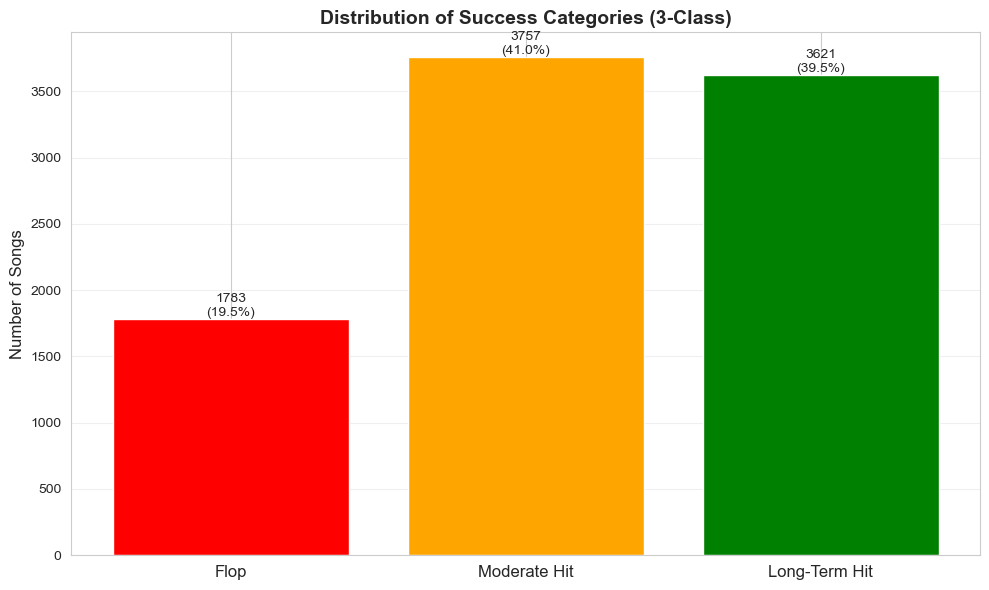

Target variable created successfully


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("STEP 1: LOADING DATA AND CREATING 3-CLASS TARGET VARIABLE")

# Load your dataset with clusters
df = pd.read_csv('Spotify_Dataset_V3_All_Clusters_v2.csv')

print("Dataset loaded")
print("Shape:", df.shape[0], "rows,", df.shape[1], "columns")
print("Date range:", df['Date'].min(), "to", df['Date'].max())

df['Date'] = pd.to_datetime(df['Date'])

print("Aggregating to song level")

song_weeks = df.groupby('id').agg({
    'Date': 'count',  # This counts number of weeks in charts
    'Title': 'first',
    'Artists': 'first',
    'Rank': 'min'  # Best rank achieved
}).reset_index()

song_weeks.columns = ['id', 'Weeks_In_Charts', 'Title', 'Artists', 'Best_Rank']

print("Unique songs:", len(song_weeks))
print("Weeks in charts distribution:")
print(song_weeks['Weeks_In_Charts'].describe())

def categorize_success_3class(weeks):
    """
    Categorize songs into 3 success levels based on chart longevity
    """
    if weeks < 2:
        return 'Flop'
    elif weeks < 20:
        return 'Moderate Hit'  # Combined Brief Hit and Sustained Success
    else:
        return 'Long-Term Hit'

song_weeks['Success_Category'] = song_weeks['Weeks_In_Charts'].apply(categorize_success_3class)

print("SUCCESS CATEGORY DISTRIBUTION (3 CLASSES)")

category_counts = song_weeks['Success_Category'].value_counts()
print("Number of songs in each category:")
for category in category_counts.index:
    count = category_counts[category]
    percent = (count / len(song_weeks)) * 100
    print(category, ":", count, "songs", "(", round(percent, 1), "% )")

# Visualize distribution
plt.figure(figsize=(10, 6))
category_order = ['Flop', 'Moderate Hit', 'Long-Term Hit']
category_counts_ordered = song_weeks['Success_Category'].value_counts().reindex(category_order)

bars = plt.bar(range(len(category_counts_ordered)), category_counts_ordered.values, 
               color=['red', 'orange', 'green'])
plt.xticks(range(len(category_counts_ordered)), category_counts_ordered.index, fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.title('Distribution of Success Categories (3-Class)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i in range(len(bars)):
    bar = bars[i]
    height = bar.get_height()
    label_text = str(int(height)) + "\n(" + str(round(category_counts_ordered.values[i]/len(song_weeks)*100, 1)) + "%)"
    plt.text(bar.get_x() + bar.get_width()/2., height,
             label_text,
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('success_category_distribution_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Target variable created successfully")

In [2]:
print("STEP 2: MERGING CLUSTER FEATURES WITH TARGET")

# Get cluster features for each song (use first appearance)
song_features = df.sort_values('Date').groupby('id').first().reset_index()

# Select only the cluster columns and original features
cluster_columns = [
    'Sonic_Cluster',
    'Artist_Tier', 
    'Temporal_Cluster',
    'Performance_Cluster',
    'Geo_Cluster_ID',
    'Collab_Cluster_ID',
    'Evo_Cluster_ID'
]

# Original features that might be useful
potential_original_features = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 
    'Acousticness', 'Instrumentalness', 'Valence',
    '# of Artist', '# of Nationality'
]

# Check which original features exist and are numeric
original_features = []
print("Checking original features...")
for col in potential_original_features:
    if col in song_features.columns:
        if pd.api.types.is_numeric_dtype(song_features[col]):
            original_features.append(col)
            print("  ", col, "- included")

# Select features
features_to_keep = ['id'] + cluster_columns + original_features
song_features_selected = song_features[features_to_keep]

# Merge with target
final_data = song_features_selected.merge(
    song_weeks[['id', 'Success_Category', 'Weeks_In_Charts', 'Best_Rank']], 
    on='id', 
    how='inner'
)

print("Final dataset shape:", final_data.shape)
print("Features:", len(cluster_columns), "cluster features +", len(original_features), "original features")

print("Checking for Missing Values:")
missing_values = final_data.isnull().sum()
if missing_values.sum() > 0:
    print("Columns with missing values:")
    for col in missing_values.index:
        if missing_values[col] > 0:
            print("  ", col, ":", missing_values[col])
else:
    print("No missing values found")

# Save the final dataset
final_data.to_csv('modeling_dataset_3_class.csv', index=False)
print("Saved: modeling_dataset_3_class.csv")

STEP 2: MERGING CLUSTER FEATURES WITH TARGET
Checking original features...
   Danceability - included
   Energy - included
   Loudness - included
   Speechiness - included
   Acousticness - included
   Instrumentalness - included
   Valence - included
Final dataset shape: (9161, 18)
Features: 7 cluster features + 7 original features
Checking for Missing Values:
No missing values found
Saved: modeling_dataset_3_class.csv


STEP 3: EXPLORATORY DATA ANALYSIS


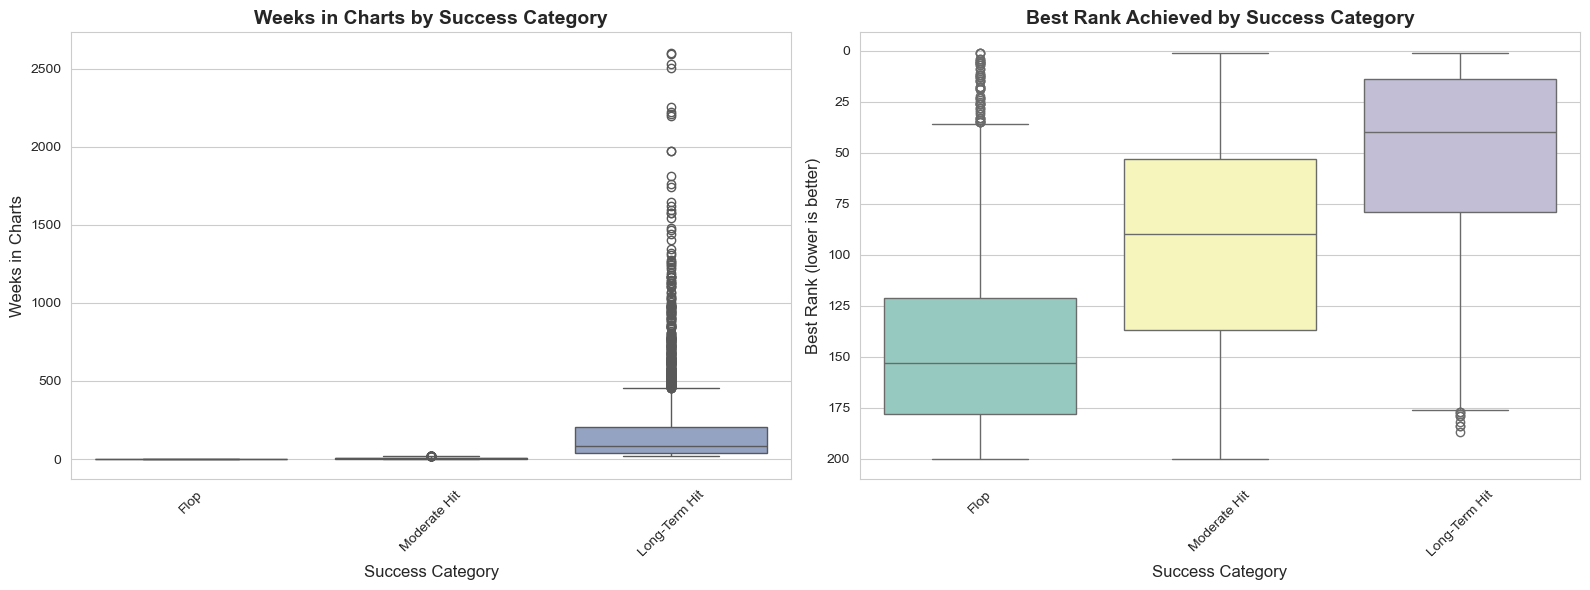

Key Statistics by Success Category:
Flop :
  Count: 1783
  Avg Weeks: 1.0
  Avg Best Rank: 144.4
Moderate Hit :
  Count: 3757
  Avg Weeks: 6.7
  Avg Best Rank: 95.3
Long-Term Hit :
  Count: 3621
  Avg Weeks: 172.6
  Avg Best Rank: 50.8


In [3]:
print("STEP 3: EXPLORATORY DATA ANALYSIS")

# Relationship between weeks and category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot: Weeks by category
category_order = ['Flop', 'Moderate Hit', 'Long-Term Hit']
sns.boxplot(data=final_data, x='Success_Category', y='Weeks_In_Charts', 
            order=category_order, ax=axes[0], palette='Set2')
axes[0].set_title('Weeks in Charts by Success Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Success Category', fontsize=12)
axes[0].set_ylabel('Weeks in Charts', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Box plot: Best Rank by category
sns.boxplot(data=final_data, x='Success_Category', y='Best_Rank', 
            order=category_order, ax=axes[1], palette='Set3')
axes[1].set_title('Best Rank Achieved by Success Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Success Category', fontsize=12)
axes[1].set_ylabel('Best Rank (lower is better)', fontsize=12)
axes[1].invert_yaxis()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('eda_target_analysis_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Key Statistics by Success Category:")
for category in category_order:
    category_data = final_data[final_data['Success_Category'] == category]
    print(category, ":")
    print("  Count:", len(category_data))
    print("  Avg Weeks:", round(category_data['Weeks_In_Charts'].mean(), 1))
    print("  Avg Best Rank:", round(category_data['Best_Rank'].mean(), 1))

CLUSTER FEATURES ACROSS SUCCESS CATEGORIES


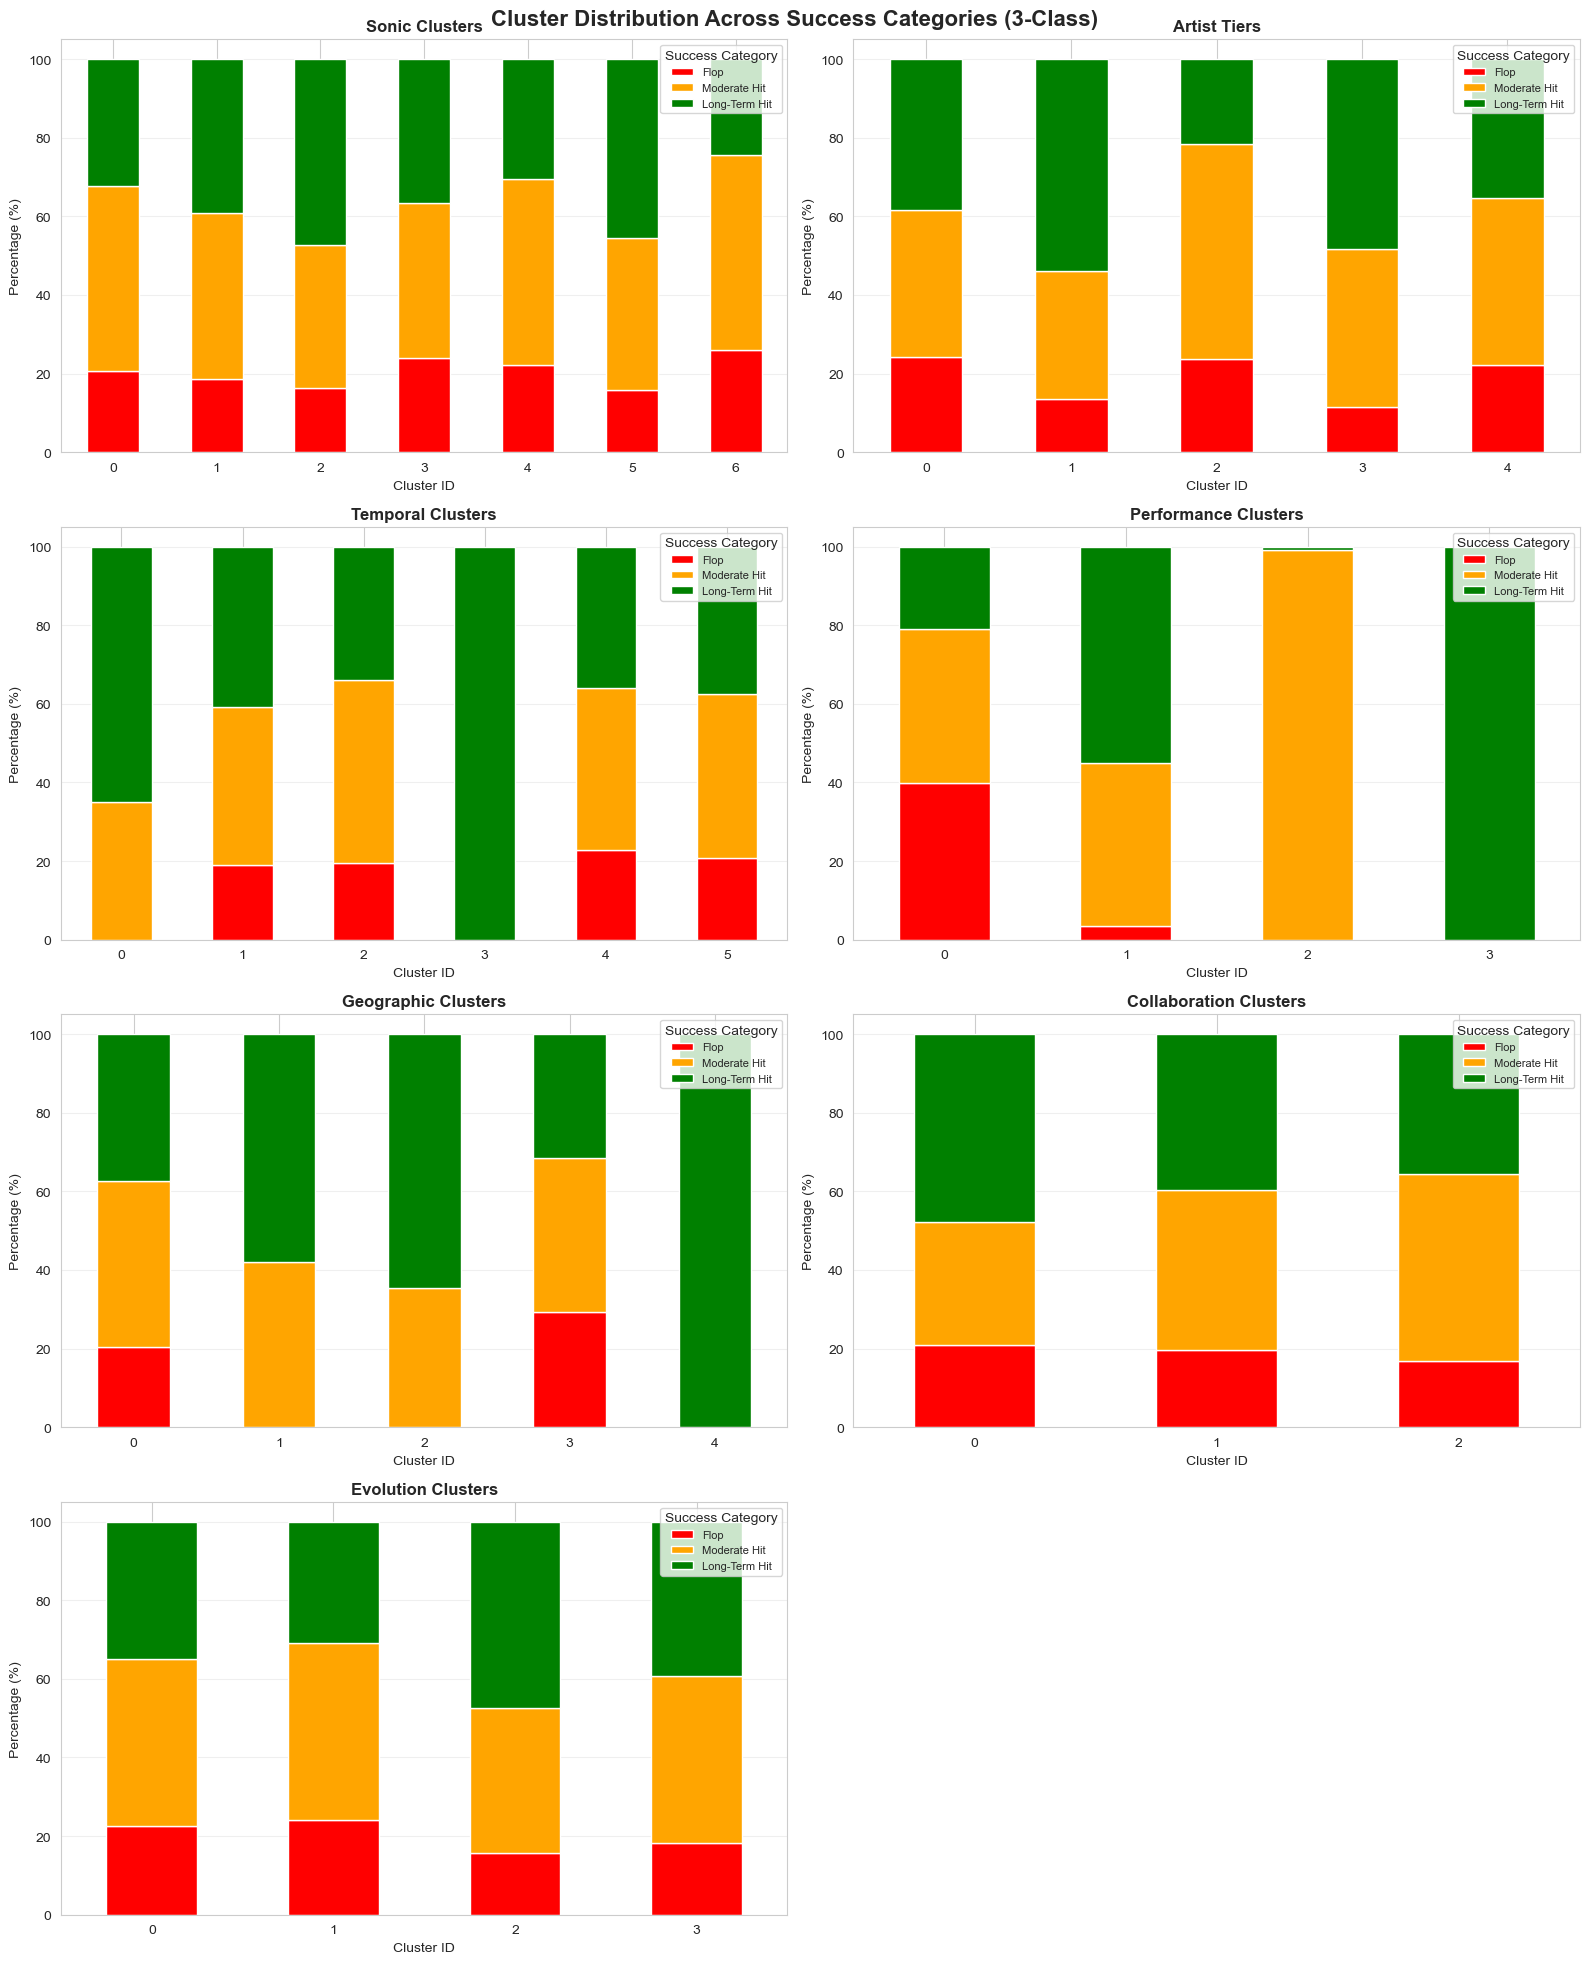

Cluster distribution analysis complete


In [4]:
print("CLUSTER FEATURES ACROSS SUCCESS CATEGORIES")

# Visualizations for each cluster dimension
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Cluster Distribution Across Success Categories (3-Class)', fontsize=16, fontweight='bold')

cluster_info = [
    ('Sonic_Cluster', 'Sonic Clusters', axes[0, 0]),
    ('Artist_Tier', 'Artist Tiers', axes[0, 1]),
    ('Temporal_Cluster', 'Temporal Clusters', axes[1, 0]),
    ('Performance_Cluster', 'Performance Clusters', axes[1, 1]),
    ('Geo_Cluster_ID', 'Geographic Clusters', axes[2, 0]),
    ('Collab_Cluster_ID', 'Collaboration Clusters', axes[2, 1]),
    ('Evo_Cluster_ID', 'Evolution Clusters', axes[3, 0])
]

for col, title, ax in cluster_info:
    # Cross-tabulation
    crosstab = pd.crosstab(final_data[col], final_data['Success_Category'], normalize='index') * 100
    crosstab = crosstab[category_order]  # Reorder columns
    
    # Stacked bar chart
    crosstab.plot(kind='bar', stacked=True, ax=ax, 
                  color=['red', 'orange', 'green'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster ID', fontsize=10)
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.legend(title='Success Category', fontsize=8, loc='upper right')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

# Remove empty subplot
axes[3, 1].remove()

plt.tight_layout()
plt.savefig('eda_cluster_distributions_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cluster distribution analysis complete")

ORIGINAL AUDIO FEATURES ACROSS SUCCESS CATEGORIES


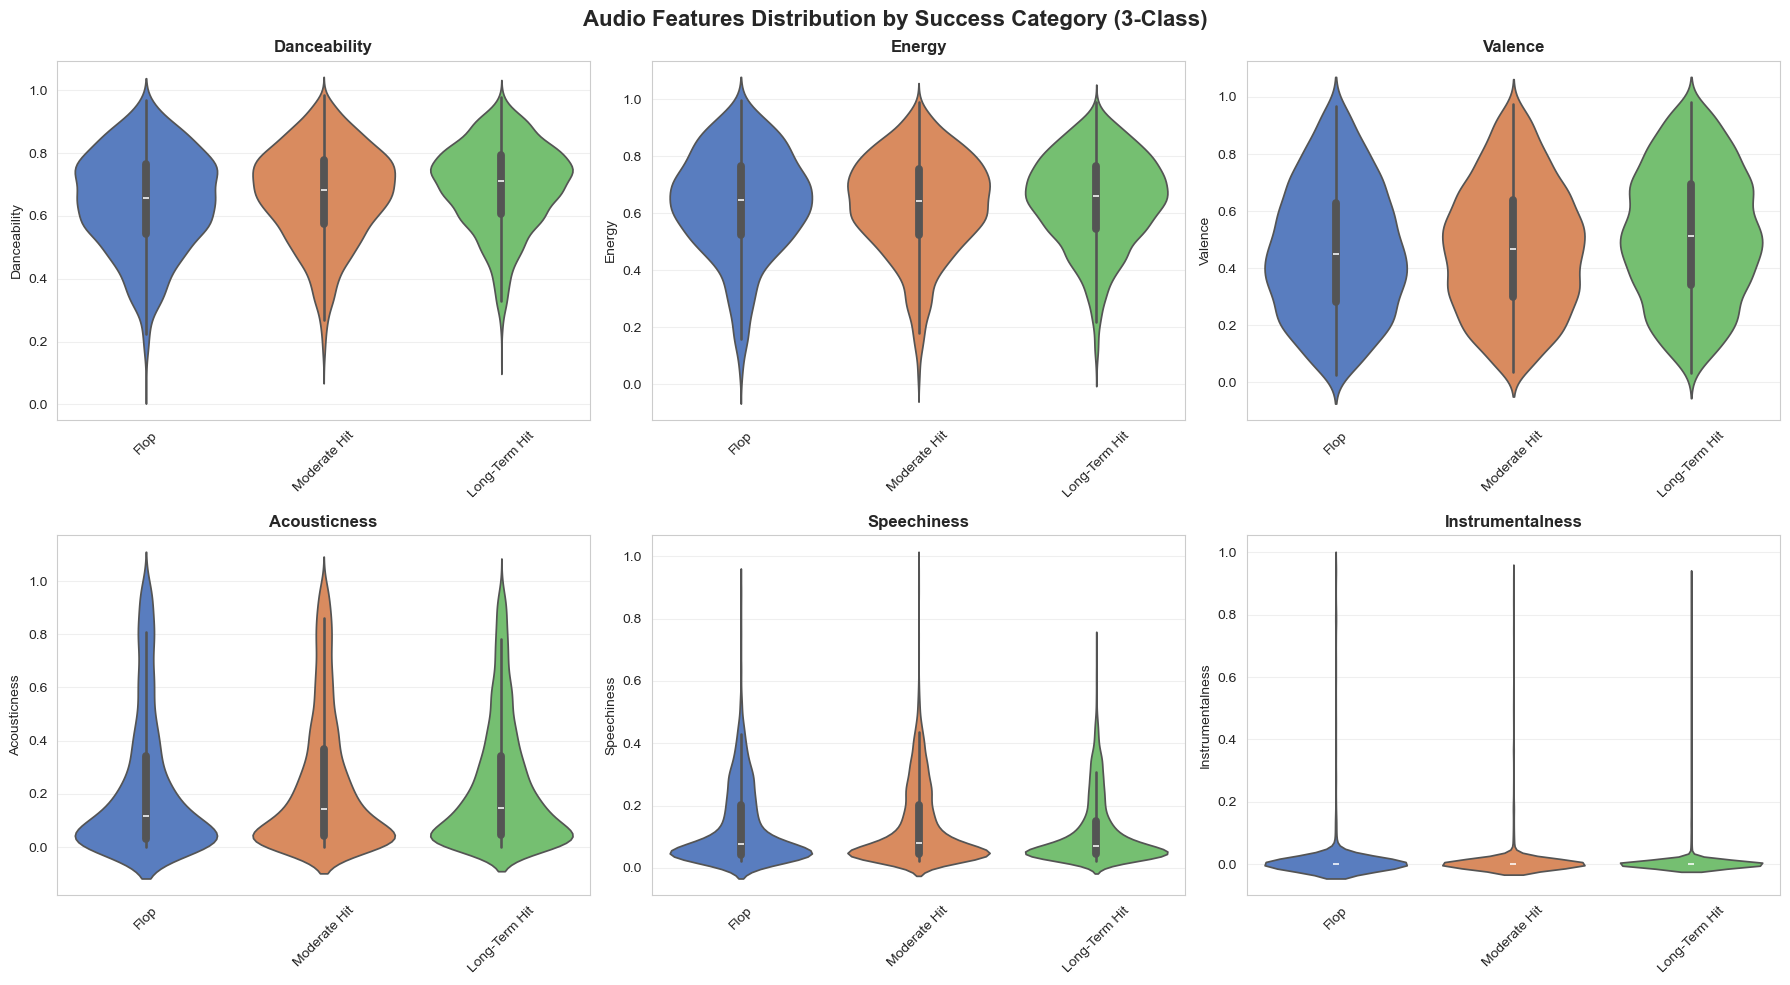

Average Audio Feature Values by Success Category:
                  Danceability  Energy  Valence  Acousticness  Speechiness  \
Success_Category                                                             
Flop                     0.646   0.633    0.461         0.228        0.135   
Moderate Hit             0.669   0.628    0.470         0.241        0.136   
Long-Term Hit            0.693   0.646    0.516         0.230        0.117   

                  Instrumentalness  
Success_Category                    
Flop                         0.018  
Moderate Hit                 0.016  
Long-Term Hit                0.010  


In [5]:
print("ORIGINAL AUDIO FEATURES ACROSS SUCCESS CATEGORIES")

# Select audio features that exist
available_audio_features = []
audio_feature_names = ['Danceability', 'Energy', 'Valence', 'Acousticness', 
                       'Speechiness', 'Instrumentalness']

for feat in audio_feature_names:
    if feat in final_data.columns:
        available_audio_features.append(feat)

# Violin plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Audio Features Distribution by Success Category (3-Class)', fontsize=16, fontweight='bold')

for idx in range(len(available_audio_features)):
    feature = available_audio_features[idx]
    row = idx // 3
    col = idx % 3
    
    sns.violinplot(data=final_data, x='Success_Category', y=feature, 
                   order=category_order, ax=axes[row, col], palette='muted')
    axes[row, col].set_title(feature, fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(axis='y', alpha=0.3)

# Removing unused subplots if fewer than 6 features
for idx in range(len(available_audio_features), 6):
    row = idx // 3
    col = idx % 3
    axes[row, col].remove()

plt.tight_layout()
plt.savefig('eda_audio_features_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Audio Feature Values by Success Category:")
audio_stats = final_data.groupby('Success_Category')[available_audio_features].mean()
audio_stats = audio_stats.reindex(category_order)
print(audio_stats.round(3))

CORRELATION ANALYSIS
Using 14 numerical features


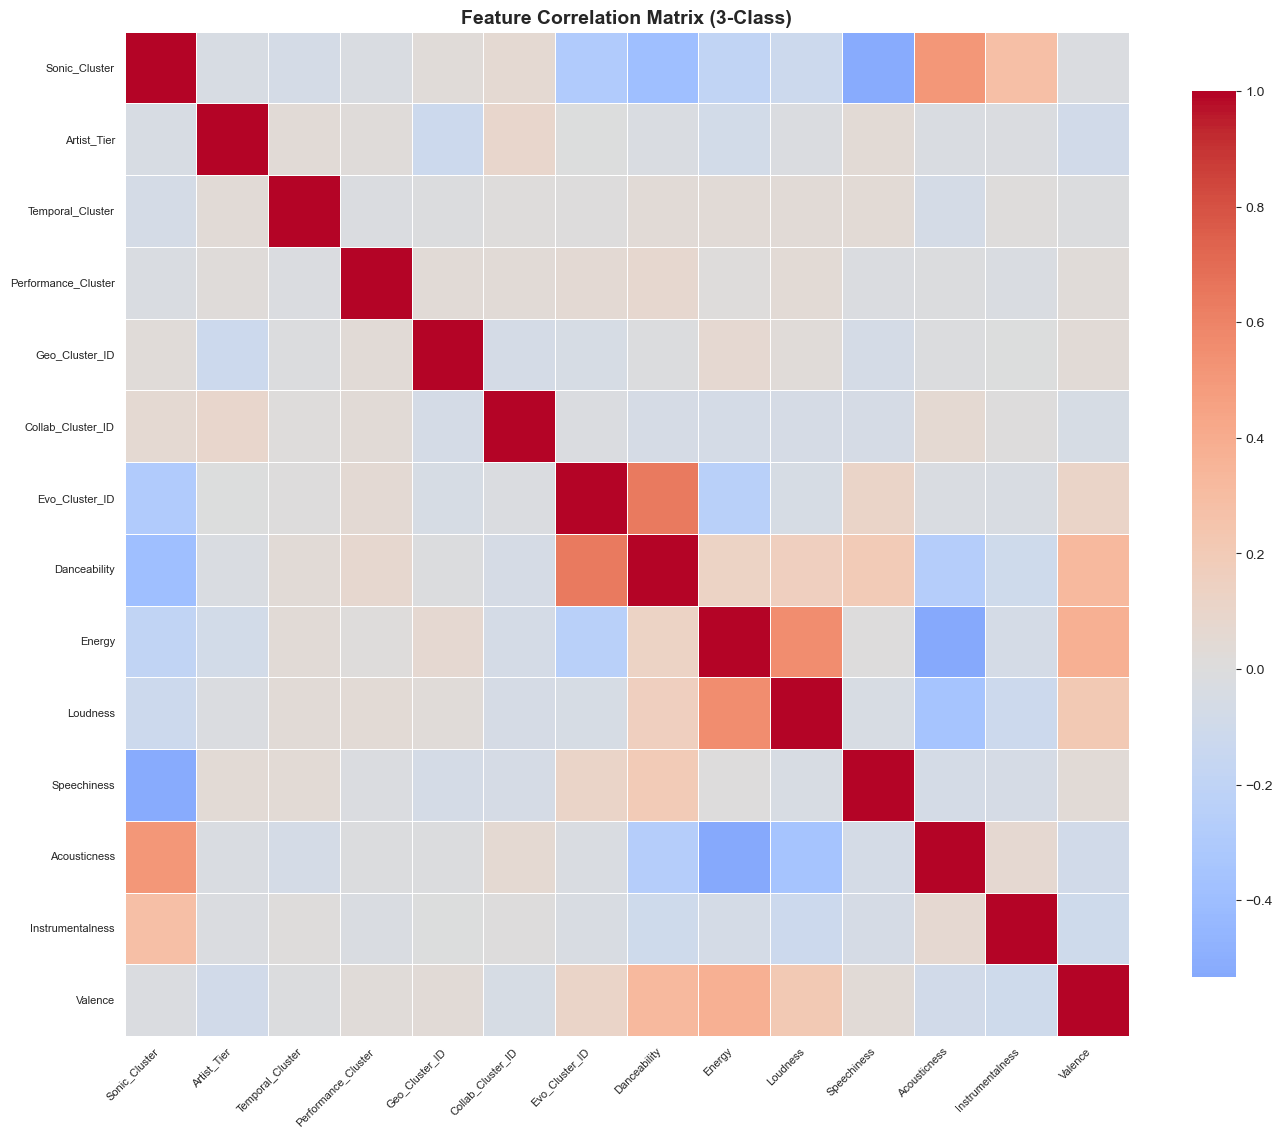

Highly Correlated Feature Pairs (correlation > 0.7):
  No highly correlated features found (good for modeling)


In [6]:
print("CORRELATION ANALYSIS")

numerical_features = cluster_columns + original_features

# Verifying all are numeric
verified_features = []
for col in numerical_features:
    if col in final_data.columns:
        if pd.api.types.is_numeric_dtype(final_data[col]):
            verified_features.append(col)

numerical_features = verified_features

print("Using", len(numerical_features), "numerical features")

# Correlation matrix
correlation_matrix = final_data[numerical_features].corr()

# Correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (3-Class)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('eda_correlation_matrix_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Highly Correlated Feature Pairs (correlation > 0.7):")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            print("  ", feat1, "<->", feat2, ":", round(corr_value, 3))
            high_corr_pairs.append((feat1, feat2, corr_value))

if len(high_corr_pairs) == 0:
    print("  No highly correlated features found (good for modeling)")

In [7]:
print("STEP 4: FEATURE PREPARATION")

# Separate features and target
X = final_data[numerical_features].copy()
y = final_data['Success_Category'].copy()

# Checking for missing values
print("Checking for missing values...")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print("Found missing values, filling with median...")
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            median_value = X[col].median()
            X[col].fillna(median_value, inplace=True)
            print("  ", col, ": filled", missing_counts[col], "missing values")
    print("Missing values handled")
else:
    print("No missing values found")

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

# Encoding target variable to numbers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Target encoding:")
for i in range(len(label_encoder.classes_)):
    category = label_encoder.classes_[i]
    count = (y_encoded == i).sum()
    print("  ", category, "->", i, "(", count, "samples )")

# Saving the encoder
import pickle
with open('label_encoder_3class.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Saved: label_encoder_3class.pkl")

# Scaling the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converting back to dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Feature Statistics After Scaling:")
print("Mean (should be close to 0):", round(X_scaled_df.mean().mean(), 6))
print("Std Dev (should be close to 1):", round(X_scaled_df.std().mean(), 6))

# Save the scaler
with open('feature_scaler_3class.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: feature_scaler_3class.pkl")
print("Feature preparation complete")

STEP 4: FEATURE PREPARATION
Checking for missing values...
No missing values found
Feature matrix shape: (9161, 14)
Target variable shape: (9161,)
Target encoding:
   Flop -> 0 ( 1783 samples )
   Long-Term Hit -> 1 ( 3621 samples )
   Moderate Hit -> 2 ( 3757 samples )
Saved: label_encoder_3class.pkl
Feature Statistics After Scaling:
Mean (should be close to 0): -0.0
Std Dev (should be close to 1): 1.000055
Saved: feature_scaler_3class.pkl
Feature preparation complete


STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)
Total features: 14
Total variance explained by all components: 100.0 %


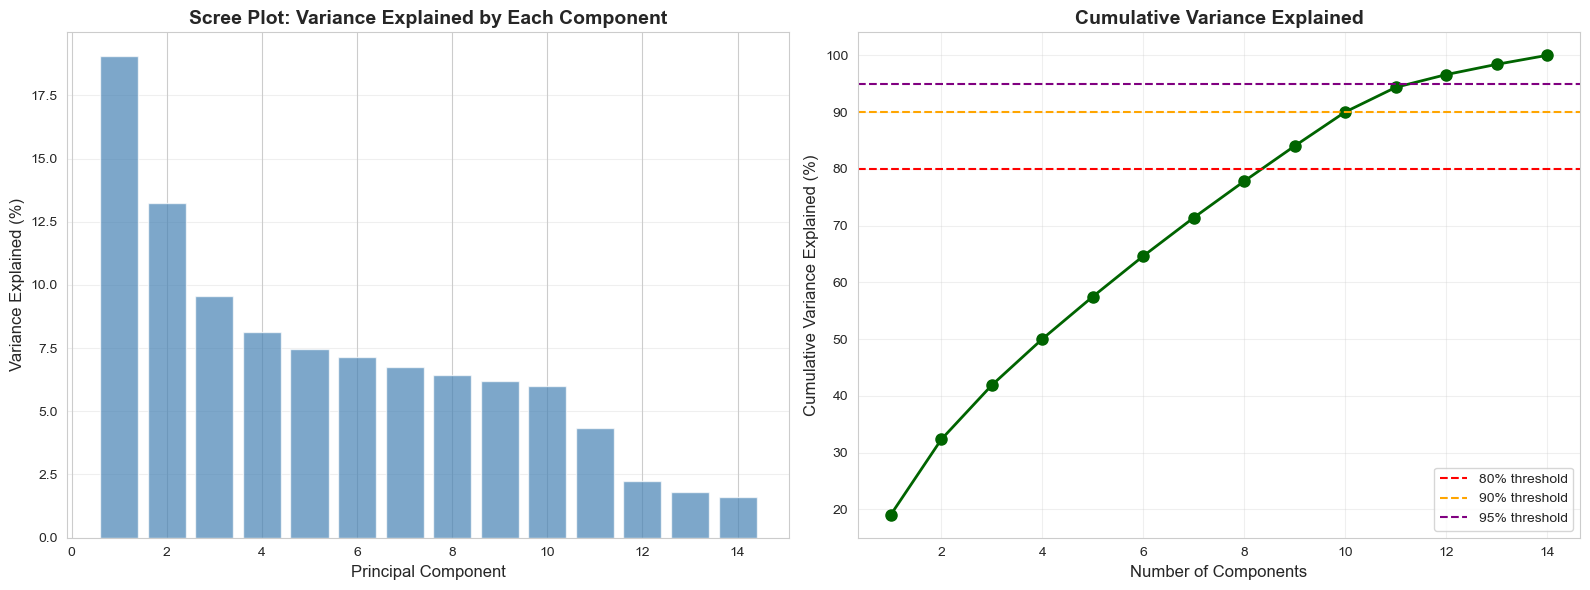

Components Needed to Explain Variance:
   80 % variance: 9 components
   85 % variance: 10 components
   90 % variance: 10 components
   95 % variance: 12 components
Optimal number of components (90% variance): 10
Original features: 14
After PCA: 10 components
Dimensionality reduction: 28.6 %
Saved: pca_transformer_3class.pkl


In [8]:
print("STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)")

from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(X_scaled)

# Calculating explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Total features:", len(X.columns))
print("Total variance explained by all components:", round(cumulative_variance[-1]*100, 2), "%")

# Plotting explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1: Scree plot
axes[0].bar(range(1, len(explained_variance)+1), explained_variance * 100, 
            color='steelblue', alpha=0.7)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained (%)', fontsize=12)
axes[0].set_title('Scree Plot: Variance Explained by Each Component', 
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2: Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance * 100, 
             marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(y=80, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90% threshold')
axes[1].axhline(y=95, color='purple', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pca_variance_analysis_3class.png', dpi=300, bbox_inches='tight')
plt.show()

# Determining optimal number of components
print("Components Needed to Explain Variance:")
thresholds = [0.80, 0.85, 0.90, 0.95]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print("  ", int(threshold*100), "% variance:", n_components, "components")

# Choosing the number of components
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print("Optimal number of components (90% variance):", optimal_components)

# Applying PCA with optimal components
pca_optimal = PCA(n_components=optimal_components)
X_pca = pca_optimal.fit_transform(X_scaled)

print("Original features:", X.shape[1])
print("After PCA:", X_pca.shape[1], "components")
reduction = (1 - X_pca.shape[1]/X.shape[1])*100
print("Dimensionality reduction:", round(reduction, 1), "%")

# Saving the PCA transformer
with open('pca_transformer_3class.pkl', 'wb') as f:
    pickle.dump(pca_optimal, f)
print("Saved: pca_transformer_3class.pkl")

In [9]:
print("STEP 6: TRAIN-TEST SPLIT")

from sklearn.model_selection import train_test_split

# Splitting using original features
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print("Original Features Split:")
print("  Training set:", X_train.shape[0], "samples")
print("  Test set:", X_test.shape[0], "samples")
split_percent = (X_test.shape[0]/len(X))*100
print("  Split ratio:", round(split_percent, 1), "% test")

# Checking class distribution in train and test
print("Class Distribution in Train Set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for idx, count in zip(train_unique, train_counts):
    category = label_encoder.classes_[idx]
    percent = (count / len(y_train)) * 100
    print("  ", category, ":", count, "(", round(percent, 1), "% )")

print("Class Distribution in Test Set:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for idx, count in zip(test_unique, test_counts):
    category = label_encoder.classes_[idx]
    percent = (count / len(y_test)) * 100
    print("  ", category, ":", count, "(", round(percent, 1), "% )")

# Also splitting the PCA-transformed data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("PCA Features Split:")
print("  Training set:", X_pca_train.shape[0], "samples,", X_pca_train.shape[1], "features")
print("  Test set:", X_pca_test.shape[0], "samples,", X_pca_test.shape[1], "features")

print("Data split completed")

STEP 6: TRAIN-TEST SPLIT
Original Features Split:
  Training set: 7328 samples
  Test set: 1833 samples
  Split ratio: 20.0 % test
Class Distribution in Train Set:
   Flop : 1426 ( 19.5 % )
   Long-Term Hit : 2897 ( 39.5 % )
   Moderate Hit : 3005 ( 41.0 % )
Class Distribution in Test Set:
   Flop : 357 ( 19.5 % )
   Long-Term Hit : 724 ( 39.5 % )
   Moderate Hit : 752 ( 41.0 % )
PCA Features Split:
  Training set: 7328 samples, 10 features
  Test set: 1833 samples, 10 features
Data split completed


In [10]:
print("STEP 7: BUILDING CLASSIFICATION MODELS")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import time

print("MODEL 1: LOGISTIC REGRESSION")

print("Training Logistic Regression...")
start_time = time.time()

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)
log_reg.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training completed in", round(training_time, 2), "seconds")

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Calculating metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='weighted')
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='weighted')

print("Performance Metrics:")
print("  Accuracy:", round(accuracy_log_reg*100, 2), "%")
print("  Precision:", round(precision_log_reg*100, 2), "%")
print("  Recall:", round(recall_log_reg*100, 2), "%")
print("  F1-Score:", round(f1_log_reg*100, 2), "%")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_log_reg, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

STEP 7: BUILDING CLASSIFICATION MODELS
MODEL 1: LOGISTIC REGRESSION
Training Logistic Regression...
Training completed in 0.03 seconds
Performance Metrics:
  Accuracy: 50.63 %
  Precision: 51.47 %
  Recall: 50.63 %
  F1-Score: 50.68 %
Detailed Classification Report:
               precision    recall  f1-score   support

         Flop       0.44      0.61      0.51       357
Long-Term Hit       0.61      0.53      0.57       724
 Moderate Hit       0.46      0.43      0.45       752

     accuracy                           0.51      1833
    macro avg       0.50      0.52      0.51      1833
 weighted avg       0.51      0.51      0.51      1833



In [11]:
print("MODEL 2: RANDOM FOREST")

from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
start_time = time.time()

random_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
random_forest.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training completed in", round(training_time, 2), "seconds")

# Make predictions
y_pred_rf = random_forest.predict(X_test)

# Calculating metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

print("Performance Metrics:")
print("  Accuracy:", round(accuracy_rf*100, 2), "%")
print("  Precision:", round(precision_rf*100, 2), "%")
print("  Recall:", round(recall_rf*100, 2), "%")
print("  F1-Score:", round(f1_rf*100, 2), "%")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_rf, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Feature Importance
print("Top 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': random_forest.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

MODEL 2: RANDOM FOREST
Training Random Forest...
Training completed in 0.13 seconds
Performance Metrics:
  Accuracy: 57.77 %
  Precision: 58.11 %
  Recall: 57.77 %
  F1-Score: 57.91 %
Detailed Classification Report:
               precision    recall  f1-score   support

         Flop       0.48      0.50      0.49       357
Long-Term Hit       0.68      0.64      0.66       724
 Moderate Hit       0.53      0.55      0.54       752

     accuracy                           0.58      1833
    macro avg       0.57      0.56      0.56      1833
 weighted avg       0.58      0.58      0.58      1833

Top 10 Most Important Features:
            Feature  Importance
Performance_Cluster    0.377234
           Loudness    0.084027
        Speechiness    0.080059
       Danceability    0.076789
            Valence    0.076621
       Acousticness    0.071847
             Energy    0.071194
   Temporal_Cluster    0.040948
     Geo_Cluster_ID    0.040703
        Artist_Tier    0.033224


In [12]:
print("MODEL 3: XGBOOST")

from xgboost import XGBClassifier

print("Training XGBoost")
start_time = time.time()

xgboost = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgboost.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training completed in", round(training_time, 2), "seconds")

# Make predictions
y_pred_xgb = xgboost.predict(X_test)

# Calculating metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')

print("Performance Metrics:")
print("  Accuracy:", round(accuracy_xgb*100, 2), "%")
print("  Precision:", round(precision_xgb*100, 2), "%")
print("  Recall:", round(recall_xgb*100, 2), "%")
print("  F1-Score:", round(f1_xgb*100, 2), "%")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Feature Importance
print("Top 10 Most Important Features:")
xgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgboost.feature_importances_
}).sort_values('Importance', ascending=False)

print(xgb_feature_importance.head(10).to_string(index=False))

MODEL 3: XGBOOST
Training XGBoost
Training completed in 0.67 seconds
Performance Metrics:
  Accuracy: 58.43 %
  Precision: 58.5 %
  Recall: 58.43 %
  F1-Score: 58.46 %
Detailed Classification Report:
               precision    recall  f1-score   support

         Flop       0.50      0.50      0.50       357
Long-Term Hit       0.67      0.66      0.66       724
 Moderate Hit       0.54      0.56      0.55       752

     accuracy                           0.58      1833
    macro avg       0.57      0.57      0.57      1833
 weighted avg       0.59      0.58      0.58      1833

Top 10 Most Important Features:
            Feature  Importance
Performance_Cluster    0.581820
     Geo_Cluster_ID    0.066645
  Collab_Cluster_ID    0.032683
   Temporal_Cluster    0.031931
        Artist_Tier    0.031776
           Loudness    0.030014
       Acousticness    0.029891
   Instrumentalness    0.028965
        Speechiness    0.028887
       Danceability    0.028791


In [14]:
print("MODEL 4: SUPPORT VECTOR MACHINE (SVM)")

from sklearn.svm import SVC

print("Training SVM")
start_time = time.time()

svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True
)
svm.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training completed in", round(training_time, 2), "seconds")

# Make predictions
y_pred_svm = svm.predict(X_test)

# Calculating metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

print("Performance Metrics:")
print("  Accuracy:", round(accuracy_svm*100, 2), "%")
print("  Precision:", round(precision_svm*100, 2), "%")
print("  Recall:", round(recall_svm*100, 2), "%")
print("  F1-Score:", round(f1_svm*100, 2), "%")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_svm, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

MODEL 4: SUPPORT VECTOR MACHINE (SVM)
Training SVM
Training completed in 5.84 seconds
Performance Metrics:
  Accuracy: 53.68 %
  Precision: 54.82 %
  Recall: 53.68 %
  F1-Score: 54.02 %
Detailed Classification Report:
               precision    recall  f1-score   support

         Flop       0.43      0.53      0.47       357
Long-Term Hit       0.65      0.56      0.60       724
 Moderate Hit       0.50      0.52      0.51       752

     accuracy                           0.54      1833
    macro avg       0.53      0.54      0.53      1833
 weighted avg       0.55      0.54      0.54      1833



In [15]:
print("MODEL 5: GRADIENT BOOSTING")

from sklearn.ensemble import GradientBoostingClassifier

print("Training Gradient Boosting")
start_time = time.time()

gradient_boost = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
gradient_boost.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training completed in", round(training_time, 2), "seconds")

# Make predictions
y_pred_gb = gradient_boost.predict(X_test)

# Calculating metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')

print("Performance Metrics:")
print("  Accuracy:", round(accuracy_gb*100, 2), "%")
print("  Precision:", round(precision_gb*100, 2), "%")
print("  Recall:", round(recall_gb*100, 2), "%")
print("  F1-Score:", round(f1_gb*100, 2), "%")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_gb, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

MODEL 5: GRADIENT BOOSTING
Training Gradient Boosting
Training completed in 3.16 seconds
Performance Metrics:
  Accuracy: 58.92 %
  Precision: 59.09 %
  Recall: 58.92 %
  F1-Score: 58.86 %
Detailed Classification Report:
               precision    recall  f1-score   support

         Flop       0.48      0.57      0.52       357
Long-Term Hit       0.67      0.69      0.68       724
 Moderate Hit       0.56      0.50      0.53       752

     accuracy                           0.59      1833
    macro avg       0.57      0.59      0.58      1833
 weighted avg       0.59      0.59      0.59      1833



STEP 8: MODEL COMPARISON
MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision    Recall  F1-Score
Logistic Regression 50.627387  51.467459 50.627387 50.681889
      Random Forest 57.774141  58.108436 57.774141 57.911678
            XGBoost 58.428805  58.500506 58.428805 58.460021
                SVM 53.682488  54.820582 53.682488 54.019664
  Gradient Boosting 58.919804  59.088951 58.919804 58.863689


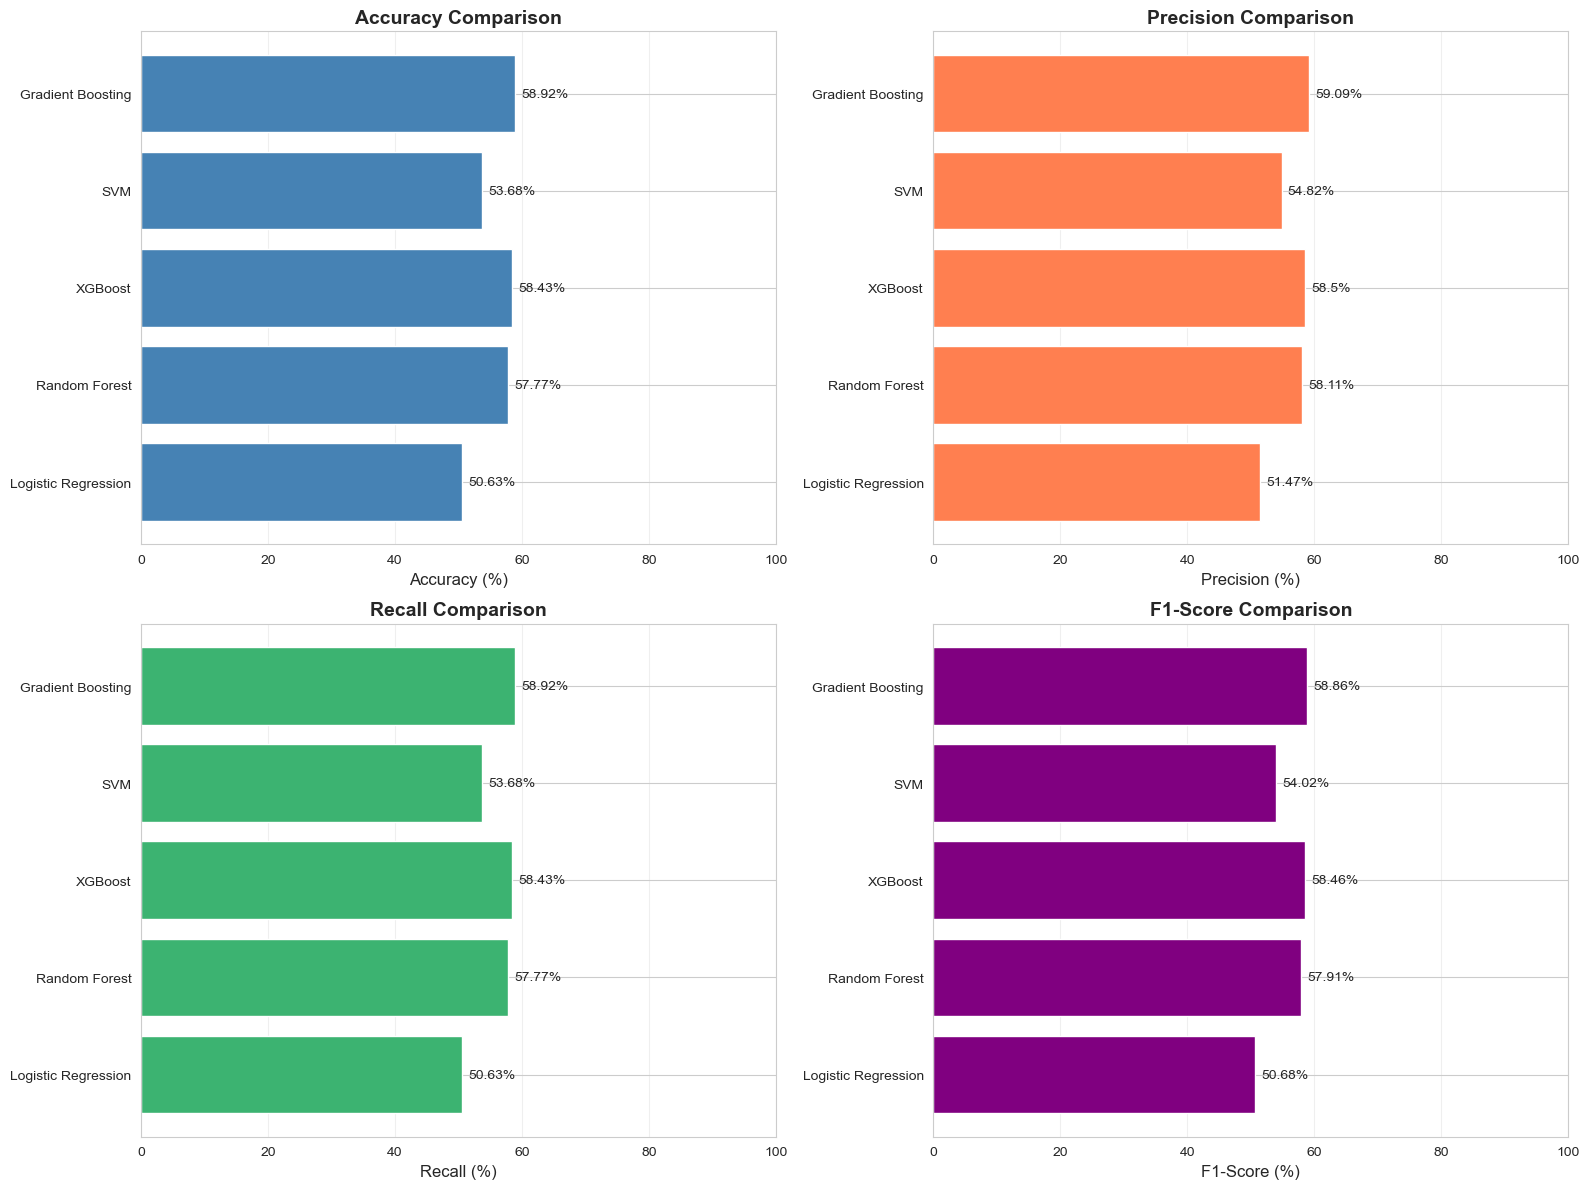

BEST MODEL: Gradient Boosting
F1-Score: 58.86 %


In [16]:
print("STEP 8: MODEL COMPARISON")

# Compiling all results
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Gradient Boosting'],
    'Accuracy': [accuracy_log_reg, accuracy_rf, accuracy_xgb, accuracy_svm, accuracy_gb],
    'Precision': [precision_log_reg, precision_rf, precision_xgb, precision_svm, precision_gb],
    'Recall': [recall_log_reg, recall_rf, recall_xgb, recall_svm, recall_gb],
    'F1-Score': [f1_log_reg, f1_rf, f1_xgb, f1_svm, f1_gb]
})

# Converting to percentages
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    model_results[col] = model_results[col] * 100

print("MODEL PERFORMANCE COMPARISON:")
print(model_results.to_string(index=False))

# Visualizing comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for idx in range(len(metrics)):
    metric = metrics[idx]
    color = colors[idx]
    row = idx // 2
    col = idx % 2
    
    axes[row, col].barh(model_results['Model'], model_results[metric], color=color)
    axes[row, col].set_xlabel(metric + ' (%)', fontsize=12)
    axes[row, col].set_title(metric + ' Comparison', fontsize=14, fontweight='bold')
    axes[row, col].set_xlim(0, 100)
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Adding value labels
    for i in range(len(model_results)):
        model_name = model_results['Model'].iloc[i]
        value = model_results[metric].iloc[i]
        axes[row, col].text(value + 1, i, str(round(value, 2)) + '%', 
                           va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison_3class.png', dpi=300, bbox_inches='tight')
plt.show()

# Finding the best model
best_model_idx = model_results['F1-Score'].idxmax()
best_model_name = model_results.loc[best_model_idx, 'Model']
best_f1_score = model_results.loc[best_model_idx, 'F1-Score']

print("BEST MODEL:", best_model_name)
print("F1-Score:", round(best_f1_score, 2), "%")

STEP 9: CONFUSION MATRICES VISUALIZATION


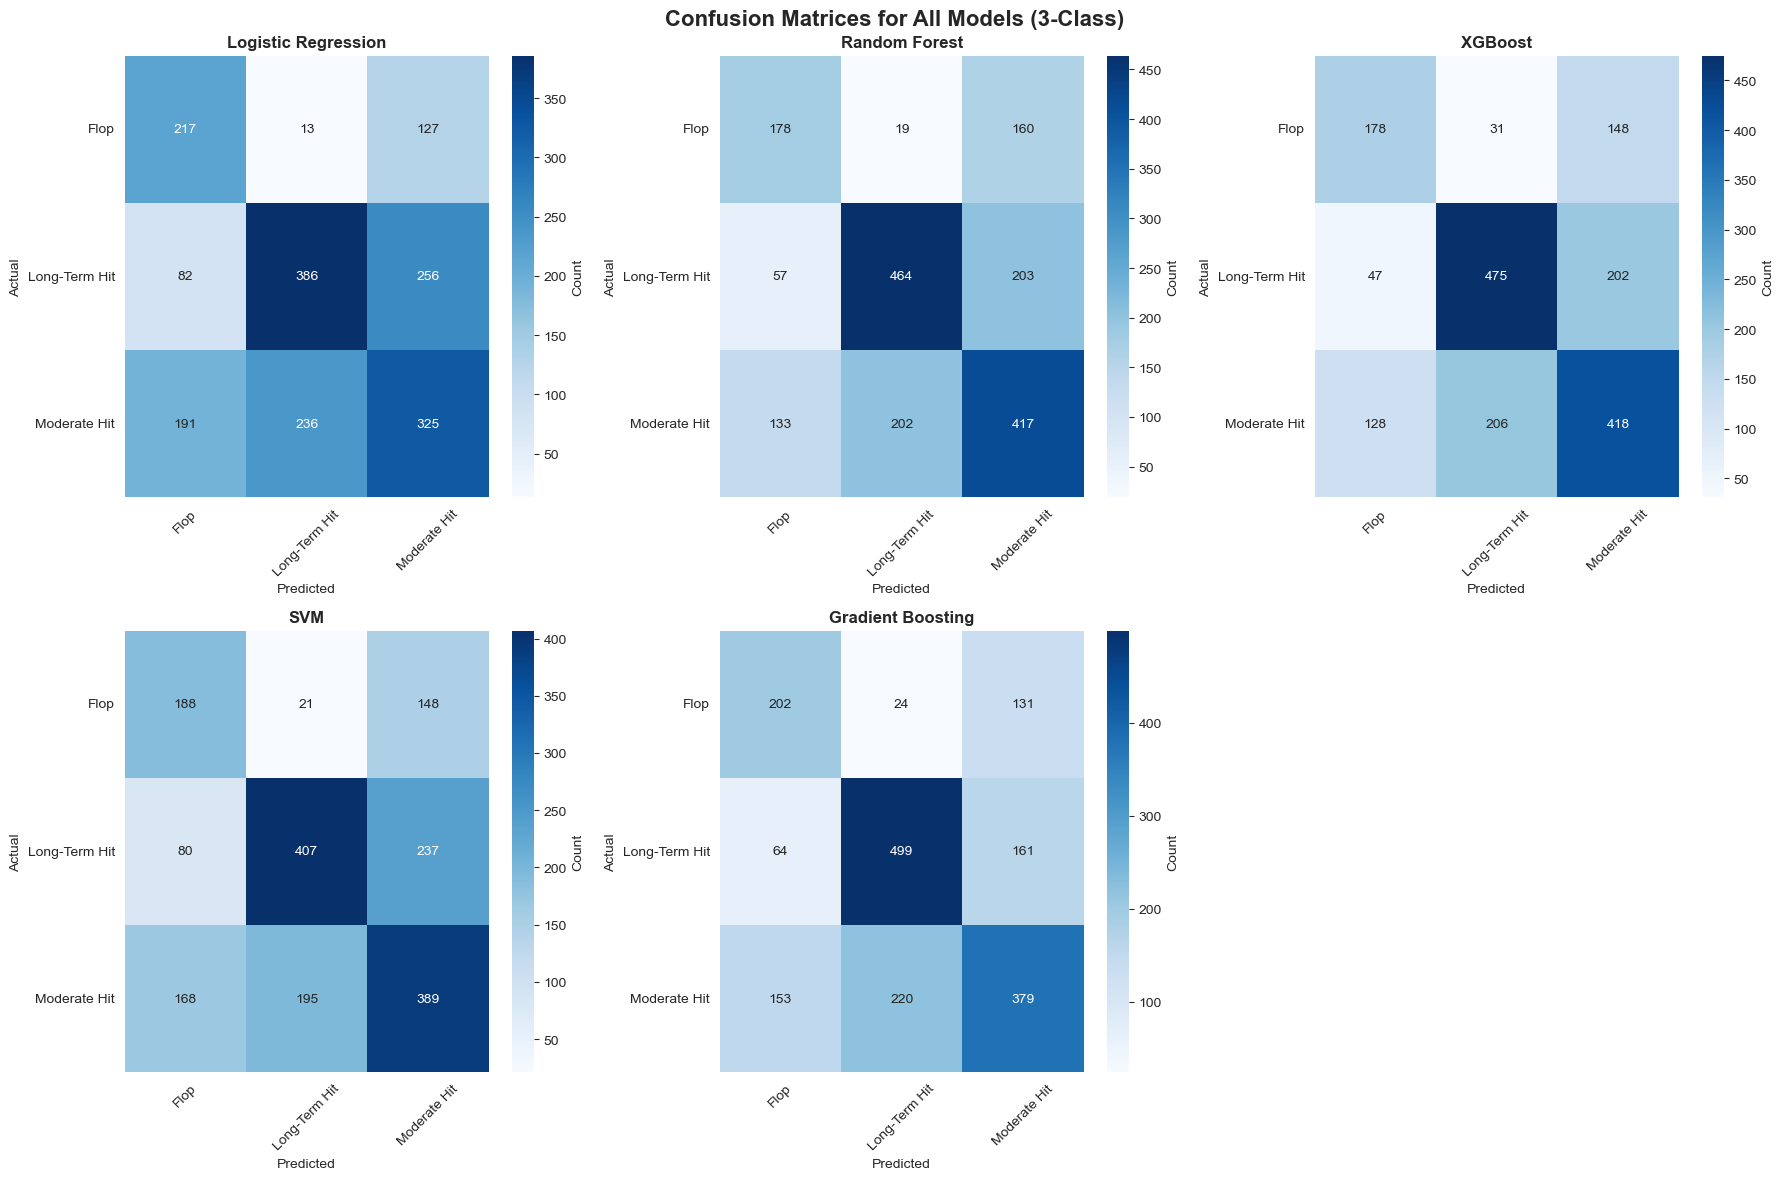

Confusion matrices visualized and saved


In [17]:
print("STEP 9: CONFUSION MATRICES VISUALIZATION")

# Confusion matrix plots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models (3-Class)', fontsize=16, fontweight='bold')

confusion_matrices = [
    (conf_matrix_log_reg, 'Logistic Regression', axes[0, 0]),
    (conf_matrix_rf, 'Random Forest', axes[0, 1]),
    (conf_matrix_xgb, 'XGBoost', axes[0, 2]),
    (conf_matrix_svm, 'SVM', axes[1, 0]),
    (conf_matrix_gb, 'Gradient Boosting', axes[1, 1])
]

for conf_matrix, title, ax in confusion_matrices:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Removing empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.savefig('confusion_matrices_all_models_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices visualized and saved")

STEP 10: HYPERPARAMETER TUNING FOR BEST MODELS
Top 2 models for hyperparameter tuning:
  1. Gradient Boosting - F1: 58.86 %
  2. XGBoost - F1: 58.46 %
TUNING MODEL 1: GRADIENT BOOSTING
Defining parameter grid for Gradient Boosting...
Parameter grid:
   n_estimators : [100, 200, 300]
   max_depth : [3, 5, 7]
   learning_rate : [0.01, 0.1, 0.2]
   subsample : [0.8, 1.0]
   min_samples_split : [10, 20]
   min_samples_leaf : [5, 10]
Total combinations to test: 216
Starting Grid Search for Gradient Boosting
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Grid search completed in 8 minutes and 26 seconds
Best Parameters Found for Gradient Boosting:
   learning_rate : 0.01
   max_depth : 7
   min_samples_leaf : 5
   min_samples_split : 10
   n_estimators : 300
   subsample : 0.8
Tuned Gradient Boosting Performance:
  Accuracy: 58.05 %
  Precision: 57.95 %
  Recall: 58.05 %
  F1-Score: 57.82 %
Comparison with original Gradient Boosting:
  Original F1-Score: 58.86 %
  Tuned F1-Sc

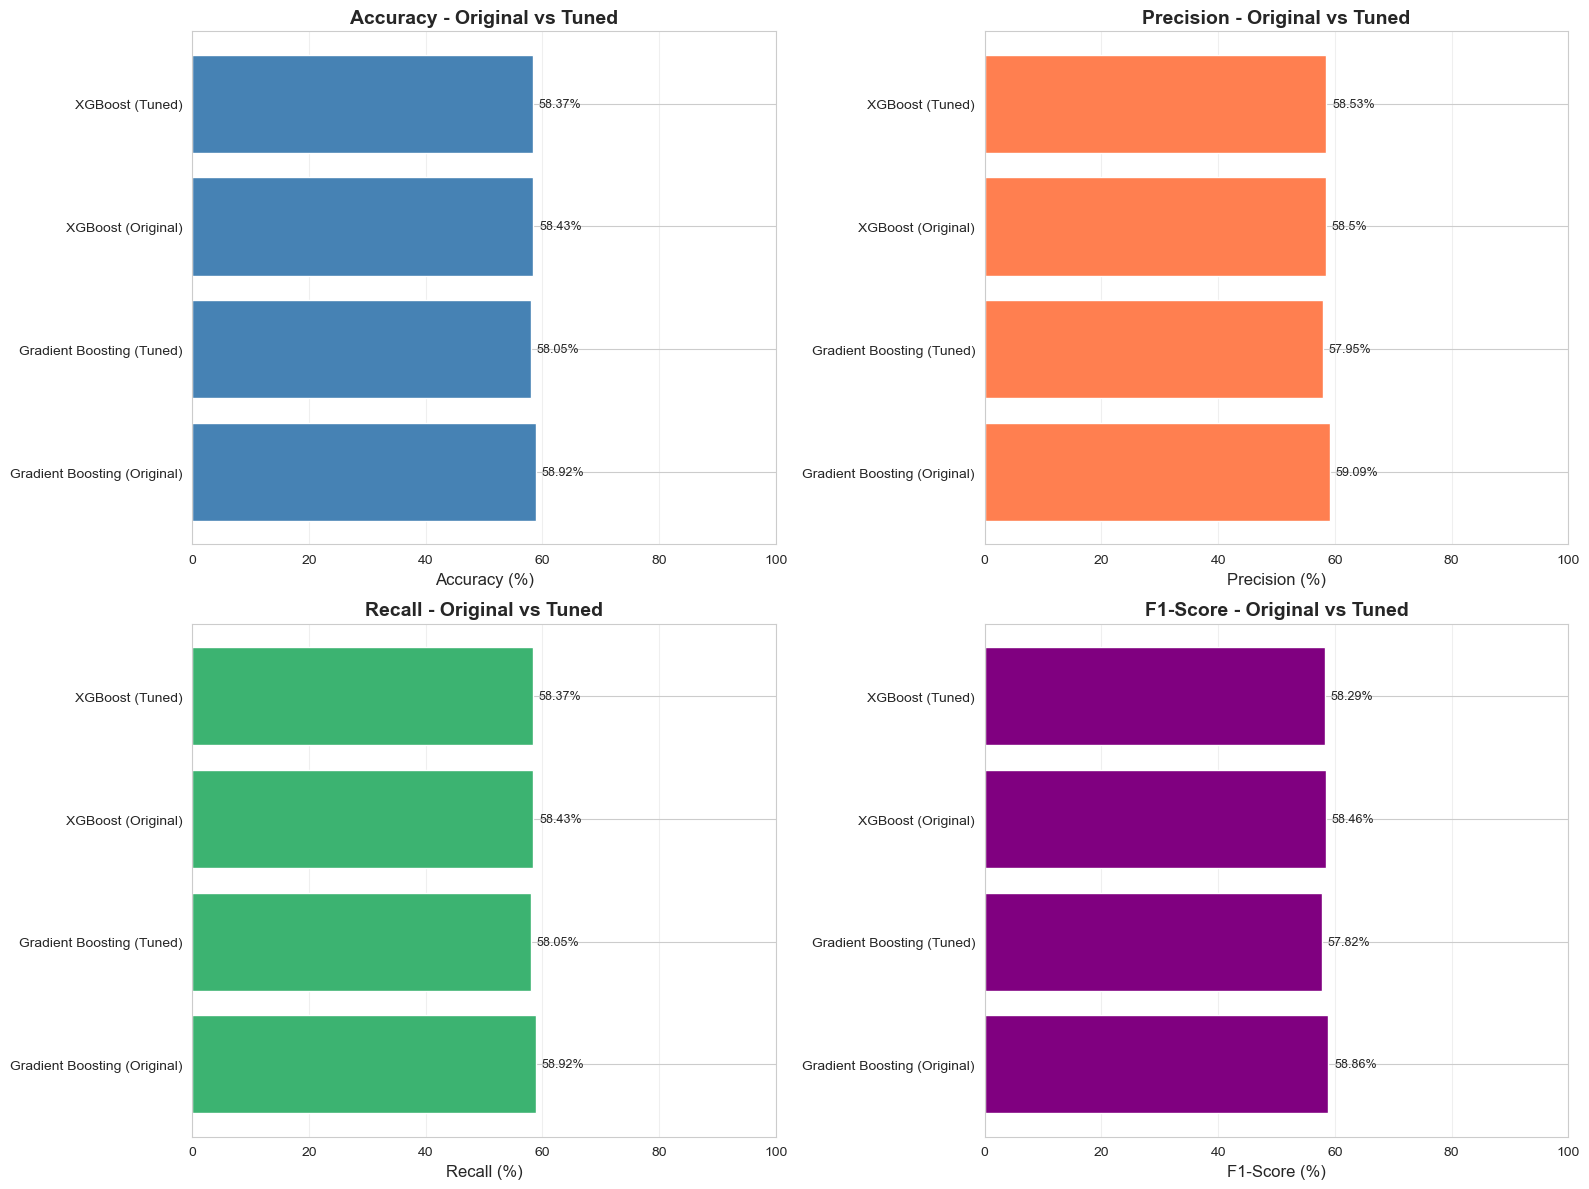

TUNING IMPACT ANALYSIS:
Gradient Boosting:
  Original F1: 58.86 %
  Tuned F1: 57.82 %
  Improvement: -1.05 percentage points
  Result: Tuning DEGRADED performance (use original)
XGBoost:
  Original F1: 58.46 %
  Tuned F1: 58.29 %
  Improvement: -0.17 percentage points
  Result: Tuning DEGRADED performance (use original)
BEST MODEL AFTER TUNING: Gradient Boosting (Original)
F1-Score: 58.86 %
Note: Original model performed better than tuned version
Creating confusion matrices for tuned models


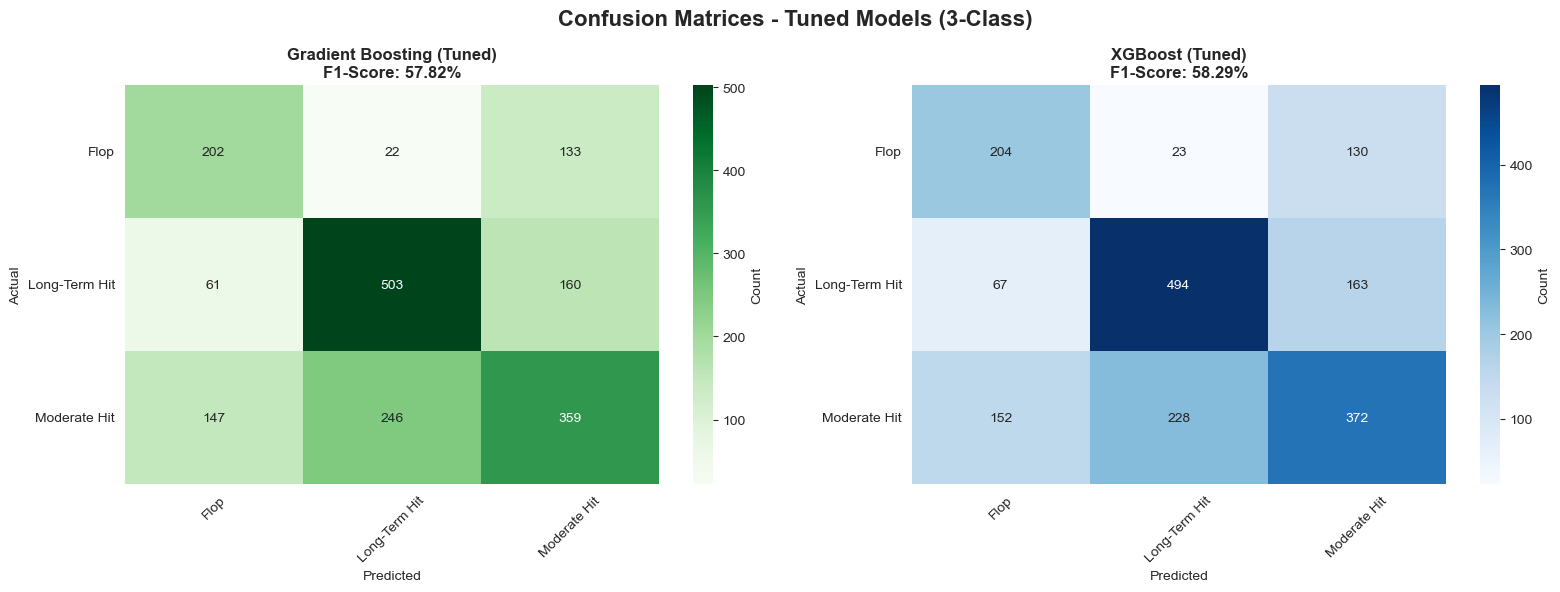

Saved: tuning_comparison_3class.csv
Hyperparameter tuning complete


In [18]:
print("STEP 10: HYPERPARAMETER TUNING FOR BEST MODELS")

from sklearn.model_selection import GridSearchCV

print("Top 2 models for hyperparameter tuning:")
print("  1. Gradient Boosting - F1:", round(f1_gb*100, 2), "%")
print("  2. XGBoost - F1:", round(f1_xgb*100, 2), "%")

print("TUNING MODEL 1: GRADIENT BOOSTING")

print("Defining parameter grid for Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

print("Parameter grid:")
for param, values in gb_param_grid.items():
    print("  ", param, ":", values)

total_combinations = 1
for values in gb_param_grid.values():
    total_combinations = total_combinations * len(values)
print("Total combinations to test:", total_combinations)

print("Starting Grid Search for Gradient Boosting")
start_time = time.time()

gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)
gb_grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
minutes = int(tuning_time / 60)
seconds = int(tuning_time % 60)
print("Grid search completed in", minutes, "minutes and", seconds, "seconds")

print("Best Parameters Found for Gradient Boosting:")
for param, value in gb_grid_search.best_params_.items():
    print("  ", param, ":", value)

# Evaluate tuned Gradient Boosting
y_pred_gb_tuned = gb_grid_search.predict(X_test)

accuracy_gb_tuned = accuracy_score(y_test, y_pred_gb_tuned)
f1_gb_tuned = f1_score(y_test, y_pred_gb_tuned, average='weighted')
precision_gb_tuned = precision_score(y_test, y_pred_gb_tuned, average='weighted')
recall_gb_tuned = recall_score(y_test, y_pred_gb_tuned, average='weighted')

print("Tuned Gradient Boosting Performance:")
print("  Accuracy:", round(accuracy_gb_tuned*100, 2), "%")
print("  Precision:", round(precision_gb_tuned*100, 2), "%")
print("  Recall:", round(recall_gb_tuned*100, 2), "%")
print("  F1-Score:", round(f1_gb_tuned*100, 2), "%")

improvement_gb = (f1_gb_tuned - f1_gb) * 100
print("Comparison with original Gradient Boosting:")
print("  Original F1-Score:", round(f1_gb*100, 2), "%")
print("  Tuned F1-Score:", round(f1_gb_tuned*100, 2), "%")
print("  Improvement:", round(improvement_gb, 2), "percentage points")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_gb_tuned, 
                          target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)

# TUNING XGBOOST (2nd place)
print("TUNING MODEL 2: XGBOOST")

print("Defining parameter grid for XGBoost")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Parameter grid:")
for param, values in xgb_param_grid.items():
    print("  ", param, ":", values)

total_combinations = 1
for values in xgb_param_grid.values():
    total_combinations = total_combinations * len(values)
print("Total combinations to test:", total_combinations)

print("Starting Grid Search for XGBoost")
start_time = time.time()

xgb_grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False),
    xgb_param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)
xgb_grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
minutes = int(tuning_time / 60)
seconds = int(tuning_time % 60)
print("Grid search completed in", minutes, "minutes and", seconds, "seconds")

print("Best Parameters Found for XGBoost:")
for param, value in xgb_grid_search.best_params_.items():
    print("  ", param, ":", value)

# Evaluate tuned XGBoost
y_pred_xgb_tuned = xgb_grid_search.predict(X_test)

accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average='weighted')
precision_xgb_tuned = precision_score(y_test, y_pred_xgb_tuned, average='weighted')
recall_xgb_tuned = recall_score(y_test, y_pred_xgb_tuned, average='weighted')

print("Tuned XGBoost Performance:")
print("  Accuracy:", round(accuracy_xgb_tuned*100, 2), "%")
print("  Precision:", round(precision_xgb_tuned*100, 2), "%")
print("  Recall:", round(recall_xgb_tuned*100, 2), "%")
print("  F1-Score:", round(f1_xgb_tuned*100, 2), "%")

improvement_xgb = (f1_xgb_tuned - f1_xgb) * 100
print("Comparison with original XGBoost:")
print("  Original F1-Score:", round(f1_xgb*100, 2), "%")
print("  Tuned F1-Score:", round(f1_xgb_tuned*100, 2), "%")
print("  Improvement:", round(improvement_xgb, 2), "percentage points")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_xgb_tuned, 
                          target_names=label_encoder.classes_))

conf_matrix_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)

print("COMPARISON: ORIGINAL VS TUNED MODELS")

tuning_comparison = pd.DataFrame({
    'Model': [
        'Gradient Boosting (Original)',
        'Gradient Boosting (Tuned)',
        'XGBoost (Original)',
        'XGBoost (Tuned)'
    ],
    'Accuracy': [
        accuracy_gb * 100,
        accuracy_gb_tuned * 100,
        accuracy_xgb * 100,
        accuracy_xgb_tuned * 100
    ],
    'Precision': [
        precision_gb * 100,
        precision_gb_tuned * 100,
        precision_xgb * 100,
        precision_xgb_tuned * 100
    ],
    'Recall': [
        recall_gb * 100,
        recall_gb_tuned * 100,
        recall_xgb * 100,
        recall_xgb_tuned * 100
    ],
    'F1-Score': [
        f1_gb * 100,
        f1_gb_tuned * 100,
        f1_xgb * 100,
        f1_xgb_tuned * 100
    ]
})

print("Performance Comparison:")
print(tuning_comparison.to_string(index=False))

# Visualizing the comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for idx in range(len(metrics)):
    metric = metrics[idx]
    color = colors[idx]
    row = idx // 2
    col = idx % 2
    
    axes[row, col].barh(tuning_comparison['Model'], tuning_comparison[metric], color=color)
    axes[row, col].set_xlabel(metric + ' (%)', fontsize=12)
    axes[row, col].set_title(metric + ' - Original vs Tuned', fontsize=14, fontweight='bold')
    axes[row, col].set_xlim(0, 100)
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Adding the value labels
    for i in range(len(tuning_comparison)):
        model = tuning_comparison['Model'].iloc[i]
        value = tuning_comparison[metric].iloc[i]
        axes[row, col].text(value + 1, i, str(round(value, 2)) + '%', 
                           va='center', fontsize=9)

plt.tight_layout()
plt.savefig('tuning_comparison_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("TUNING IMPACT ANALYSIS:")

print("Gradient Boosting:")
print("  Original F1:", round(f1_gb*100, 2), "%")
print("  Tuned F1:", round(f1_gb_tuned*100, 2), "%")
print("  Improvement:", round(improvement_gb, 2), "percentage points")
if improvement_gb > 0:
    print("  Result: Tuning IMPROVED performance")
elif improvement_gb < 0:
    print("  Result: Tuning DEGRADED performance (use original)")
else:
    print("  Result: No change")

print("XGBoost:")
print("  Original F1:", round(f1_xgb*100, 2), "%")
print("  Tuned F1:", round(f1_xgb_tuned*100, 2), "%")
print("  Improvement:", round(improvement_xgb, 2), "percentage points")
if improvement_xgb > 0:
    print("  Result: Tuning IMPROVED performance")
elif improvement_xgb < 0:
    print("  Result: Tuning DEGRADED performance (use original)")
else:
    print("  Result: No change")

all_f1_scores = {
    'Gradient Boosting (Original)': f1_gb * 100,
    'Gradient Boosting (Tuned)': f1_gb_tuned * 100,
    'XGBoost (Original)': f1_xgb * 100,
    'XGBoost (Tuned)': f1_xgb_tuned * 100
}

best_model_name_after_tuning = max(all_f1_scores, key=all_f1_scores.get)
best_f1_after_tuning = all_f1_scores[best_model_name_after_tuning]

print("BEST MODEL AFTER TUNING:", best_model_name_after_tuning)
print("F1-Score:", round(best_f1_after_tuning, 2), "%")

# Map to actual model and predictions
if best_model_name_after_tuning == 'Gradient Boosting (Tuned)':
    best_model_after_tuning = gb_grid_search.best_estimator_
    best_predictions_after_tuning = y_pred_gb_tuned
    best_params_after_tuning = gb_grid_search.best_params_
    best_conf_matrix_after_tuning = conf_matrix_gb_tuned
elif best_model_name_after_tuning == 'Gradient Boosting (Original)':
    best_model_after_tuning = gradient_boost
    best_predictions_after_tuning = y_pred_gb
    best_params_after_tuning = None
    best_conf_matrix_after_tuning = conf_matrix_gb
elif best_model_name_after_tuning == 'XGBoost (Tuned)':
    best_model_after_tuning = xgb_grid_search.best_estimator_
    best_predictions_after_tuning = y_pred_xgb_tuned
    best_params_after_tuning = xgb_grid_search.best_params_
    best_conf_matrix_after_tuning = conf_matrix_xgb_tuned
else:
    best_model_after_tuning = xgboost
    best_predictions_after_tuning = y_pred_xgb
    best_params_after_tuning = None
    best_conf_matrix_after_tuning = conf_matrix_xgb

if best_params_after_tuning is not None:
    print("Best Hyperparameters:")
    for param, value in best_params_after_tuning.items():
        print("  ", param, ":", value)
else:
    print("Note: Original model performed better than tuned version")

print("Creating confusion matrices for tuned models")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Confusion Matrices - Tuned Models (3-Class)', fontsize=16, fontweight='bold')

# Gradient Boosting Tuned
sns.heatmap(conf_matrix_gb_tuned, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Gradient Boosting (Tuned)\nF1-Score: ' + str(round(f1_gb_tuned*100, 2)) + '%', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=10)
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# XGBoost Tuned
sns.heatmap(conf_matrix_xgb_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('XGBoost (Tuned)\nF1-Score: ' + str(round(f1_xgb_tuned*100, 2)) + '%', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=10)
axes[1].set_ylabel('Actual', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('tuned_models_confusion_matrices_3class.png', dpi=300, bbox_inches='tight')
plt.show()

# Saving comparison
tuning_comparison.to_csv('tuning_comparison_3class.csv', index=False)
print("Saved: tuning_comparison_3class.csv")

print("Hyperparameter tuning complete")

STEP 11: HANDLING CLASS IMBALANCE WITH SMOTE
Trying SMOTE to address potential class imbalance
Original class distribution in training set:
   Flop : 1426 ( 19.5 % )
   Long-Term Hit : 2897 ( 39.5 % )
   Moderate Hit : 3005 ( 41.0 % )
Imbalance Ratio: 2.11 :1
Class imbalance detected - applying SMOTE
Applying SMOTE (Synthetic Minority Over-sampling Technique)
After SMOTE:
   Flop : 3005 ( 33.3 % )
   Long-Term Hit : 3005 ( 33.3 % )
   Moderate Hit : 3005 ( 33.3 % )
Training set size before SMOTE: 7328
Training set size after SMOTE: 9015
Training Gradient Boosting with SMOTE data...
Gradient Boosting with SMOTE Performance:
  Accuracy: 58.37 %
  Precision: 59.39 %
  Recall: 58.37 %
  F1-Score: 58.2 %
Comparison with original Gradient Boosting:
  Original F1-Score: 58.86 %
  SMOTE F1-Score: 58.2 %
  Improvement: -0.66 percentage points
Classification Report:
               precision    recall  f1-score   support

         Flop       0.46      0.66      0.54       357
Long-Term Hit       

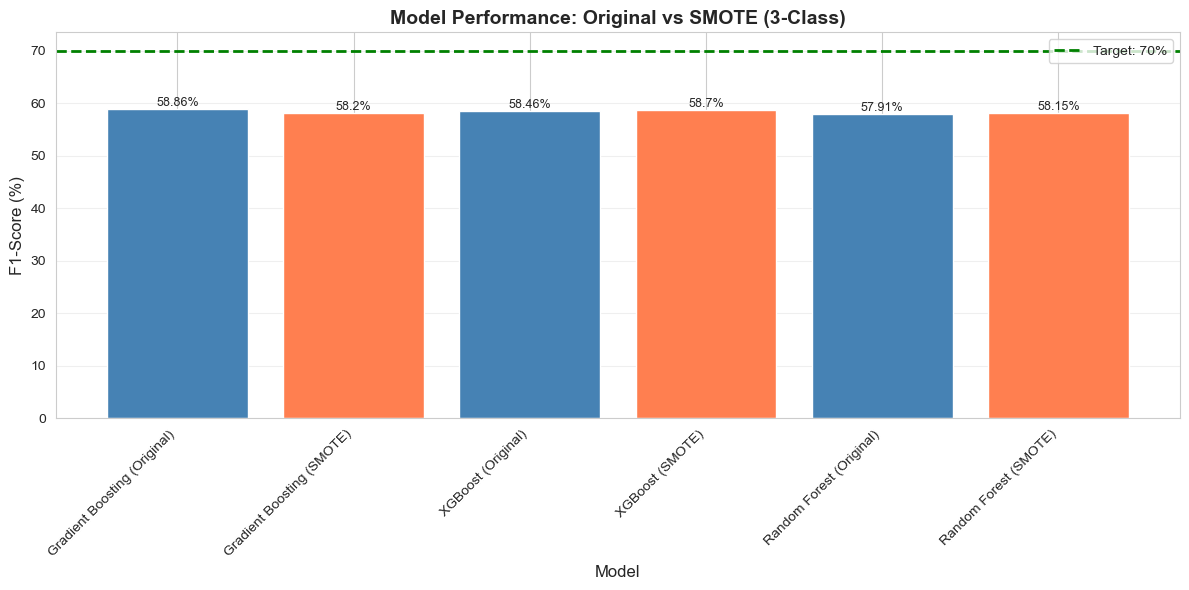

SMOTE application complete


In [20]:
print("STEP 11: HANDLING CLASS IMBALANCE WITH SMOTE")

# Since tuning didn't improve performance, trying SMOTE with original models
print("Trying SMOTE to address potential class imbalance")

# Checking class imbalance first
print("Original class distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for idx, count in zip(train_unique, train_counts):
    category = label_encoder.classes_[idx]
    percent = (count / len(y_train)) * 100
    print("  ", category, ":", count, "(", round(percent, 1), "% )")

# Calculating imbalance ratio
max_class = train_counts.max()
min_class = train_counts.min()
imbalance_ratio = max_class / min_class
print("Imbalance Ratio:", round(imbalance_ratio, 2), ":1")

if imbalance_ratio > 1.5:
    print("Class imbalance detected - applying SMOTE")
else:
    print("Classes are relatively balanced")

# Applying SMOTE
from imblearn.over_sampling import SMOTE

print("Applying SMOTE (Synthetic Minority Over-sampling Technique)")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
smote_unique, smote_counts = np.unique(y_train_smote, return_counts=True)
for idx, count in zip(smote_unique, smote_counts):
    category = label_encoder.classes_[idx]
    percent = (count / len(y_train_smote)) * 100
    print("  ", category, ":", count, "(", round(percent, 1), "% )")

print("Training set size before SMOTE:", len(X_train))
print("Training set size after SMOTE:", len(X_train_smote))

# Training Gradient Boosting with SMOTE
print("Training Gradient Boosting with SMOTE data...")

gb_smote = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
gb_smote.fit(X_train_smote, y_train_smote)

y_pred_gb_smote = gb_smote.predict(X_test)
f1_gb_smote = f1_score(y_test, y_pred_gb_smote, average='weighted')
accuracy_gb_smote = accuracy_score(y_test, y_pred_gb_smote)
precision_gb_smote = precision_score(y_test, y_pred_gb_smote, average='weighted')
recall_gb_smote = recall_score(y_test, y_pred_gb_smote, average='weighted')

print("Gradient Boosting with SMOTE Performance:")
print("  Accuracy:", round(accuracy_gb_smote*100, 2), "%")
print("  Precision:", round(precision_gb_smote*100, 2), "%")
print("  Recall:", round(recall_gb_smote*100, 2), "%")
print("  F1-Score:", round(f1_gb_smote*100, 2), "%")

improvement_gb_smote = (f1_gb_smote - f1_gb) * 100
print("Comparison with original Gradient Boosting:")
print("  Original F1-Score:", round(f1_gb*100, 2), "%")
print("  SMOTE F1-Score:", round(f1_gb_smote*100, 2), "%")
print("  Improvement:", round(improvement_gb_smote, 2), "percentage points")

print("Classification Report:")
print(classification_report(y_test, y_pred_gb_smote, 
                          target_names=label_encoder.classes_))

conf_matrix_gb_smote = confusion_matrix(y_test, y_pred_gb_smote)

# Training XGBoost with SMOTE
print("Training XGBoost with SMOTE data...")

xgb_smote = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_xgb_smote = xgb_smote.predict(X_test)
f1_xgb_smote = f1_score(y_test, y_pred_xgb_smote, average='weighted')
accuracy_xgb_smote = accuracy_score(y_test, y_pred_xgb_smote)
precision_xgb_smote = precision_score(y_test, y_pred_xgb_smote, average='weighted')
recall_xgb_smote = recall_score(y_test, y_pred_xgb_smote, average='weighted')

print("XGBoost with SMOTE Performance:")
print("  Accuracy:", round(accuracy_xgb_smote*100, 2), "%")
print("  Precision:", round(precision_xgb_smote*100, 2), "%")
print("  Recall:", round(recall_xgb_smote*100, 2), "%")
print("  F1-Score:", round(f1_xgb_smote*100, 2), "%")

improvement_xgb_smote = (f1_xgb_smote - f1_xgb) * 100
print("Comparison with original XGBoost:")
print("  Original F1-Score:", round(f1_xgb*100, 2), "%")
print("  SMOTE F1-Score:", round(f1_xgb_smote*100, 2), "%")
print("  Improvement:", round(improvement_xgb_smote, 2), "percentage points")

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_smote, 
                          target_names=label_encoder.classes_))

conf_matrix_xgb_smote = confusion_matrix(y_test, y_pred_xgb_smote)

# Training Random Forest with SMOTE (for comparison)
print("Training Random Forest with SMOTE data...")

rf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_rf_smote = rf_smote.predict(X_test)
f1_rf_smote = f1_score(y_test, y_pred_rf_smote, average='weighted')
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)

print("Random Forest with SMOTE Performance:")
print("  Accuracy:", round(accuracy_rf_smote*100, 2), "%")
print("  F1-Score:", round(f1_rf_smote*100, 2), "%")
print("  Improvement:", round((f1_rf_smote - f1_rf)*100, 2), "percentage points")

# Comparing all the SMOTE results
print("SMOTE IMPACT COMPARISON:")

smote_comparison = pd.DataFrame({
    'Model': [
        'Gradient Boosting (Original)',
        'Gradient Boosting (SMOTE)',
        'XGBoost (Original)',
        'XGBoost (SMOTE)',
        'Random Forest (Original)',
        'Random Forest (SMOTE)'
    ],
    'F1-Score': [
        f1_gb * 100,
        f1_gb_smote * 100,
        f1_xgb * 100,
        f1_xgb_smote * 100,
        f1_rf * 100,
        f1_rf_smote * 100
    ],
    'Improvement': [
        0,
        improvement_gb_smote,
        0,
        improvement_xgb_smote,
        0,
        (f1_rf_smote - f1_rf) * 100
    ]
})

print(smote_comparison.to_string(index=False))

# Visualizing the SMOTE comparison
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(smote_comparison))
colors = ['steelblue' if 'Original' in model else 'coral' for model in smote_comparison['Model']]
bars = plt.bar(x_pos, smote_comparison['F1-Score'], color=colors)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score (%)', fontsize=12)
plt.title('Model Performance: Original vs SMOTE (3-Class)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, smote_comparison['Model'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=70, color='green', linestyle='--', linewidth=2, label='Target: 70%')
plt.legend()

# Adding the value labels
for i in range(len(bars)):
    bar = bars[i]
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(round(height, 2)) + '%',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('smote_comparison_3class.png', dpi=300, bbox_inches='tight')
plt.show()

print("SMOTE application complete")

STEP 12: FINAL MODEL SELECTION
COMPLETE MODEL COMPARISON (ALL APPROACHES):
                    Model  F1-Score
        Gradient Boosting 58.863689
          XGBoost (SMOTE) 58.702248
                  XGBoost 58.460021
          XGBoost (Tuned) 58.293307
Gradient Boosting (SMOTE) 58.203639
    Random Forest (SMOTE) 58.154158
            Random Forest 57.911678
Gradient Boosting (Tuned) 57.817684
                      SVM 54.019664
      Logistic Regression 50.681889
BEST MODEL: Gradient Boosting
F1-Score: 58.86 %
Final Model Performance:
  Accuracy: 58.92 %
  Precision: 59.09 %
  Recall: 58.92 %
  F1-Score: 58.86 %
Note: Using default/original hyperparameters
Detailed Classification Report:
               precision    recall  f1-score   support

         Flop       0.48      0.57      0.52       357
Long-Term Hit       0.67      0.69      0.68       724
 Moderate Hit       0.56      0.50      0.53       752

     accuracy                           0.59      1833
    macro avg       0.5

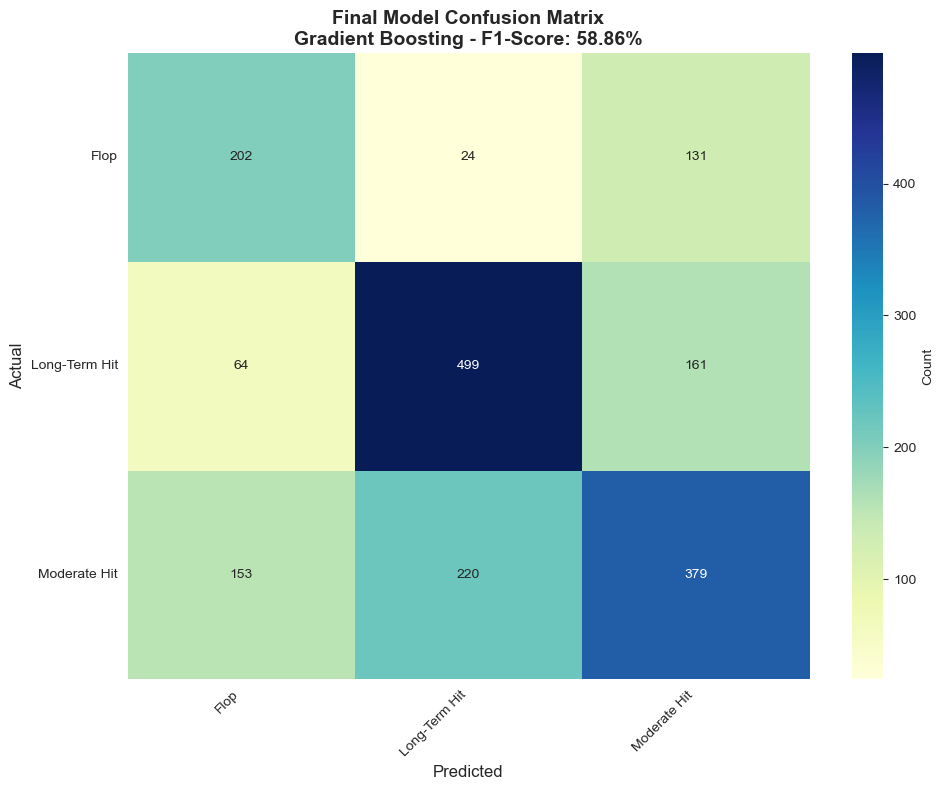

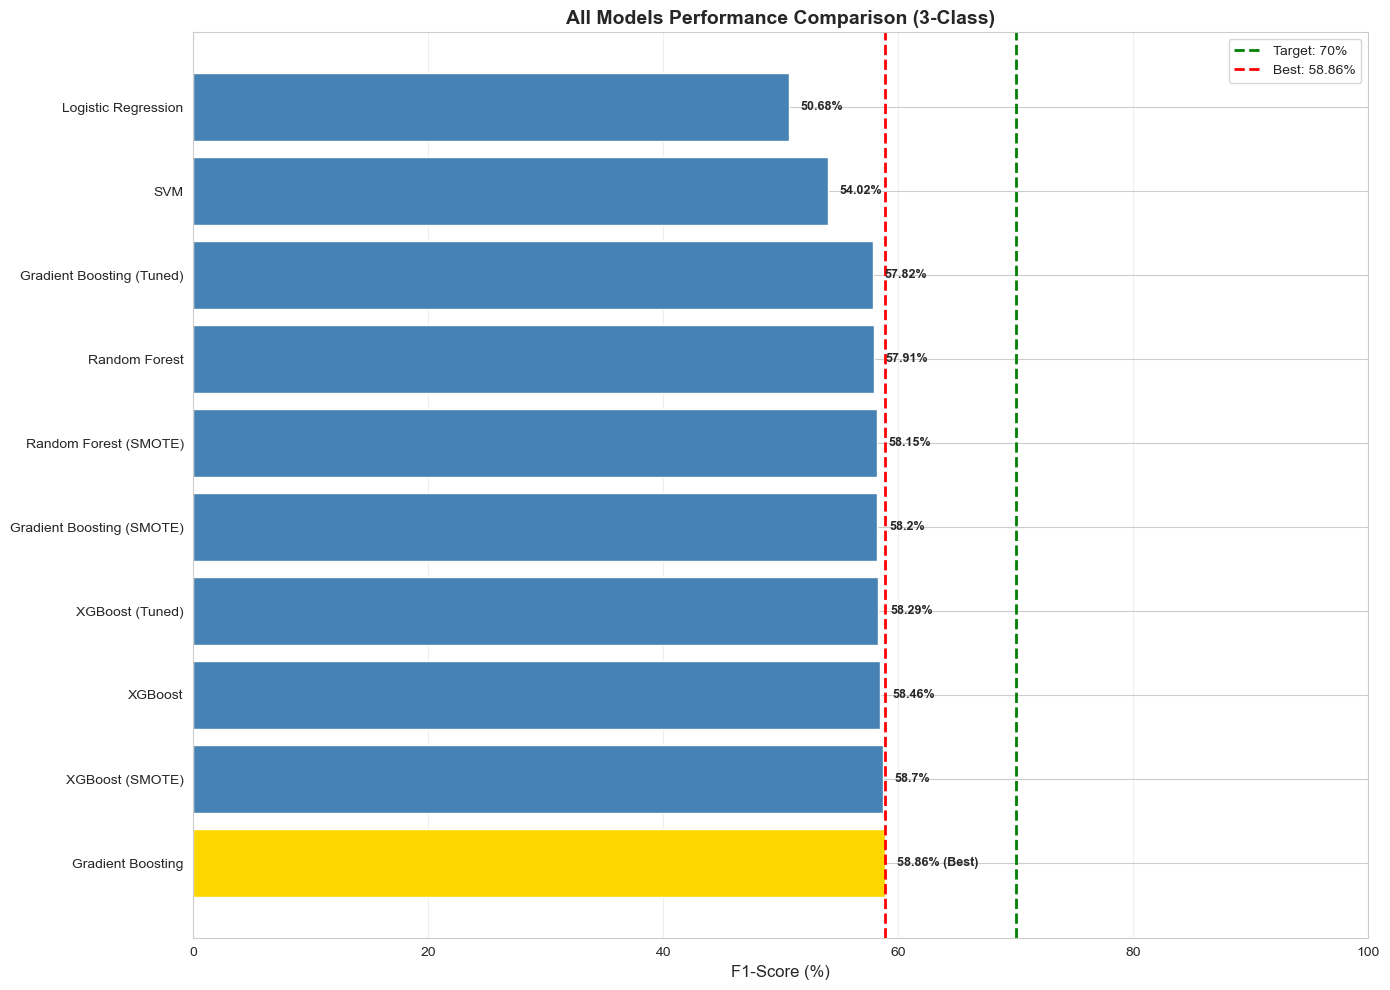

KEY INSIGHTS FROM MODEL SELECTION:
1. Best Performing Model:
   - Gradient Boosting achieved 58.86 % F1-Score
   - This is the highest performing model across all approaches
2. Hyperparameter Tuning Results:
   - Gradient Boosting (Original): 58.86 %
   - Gradient Boosting (Tuned): 57.82 %
   - Change: -1.05 percentage points
   - XGBoost (Original): 58.46 %
   - XGBoost (Tuned): 58.29 %
   - Change: -0.17 percentage points
   - Conclusion: Tuning degraded performance - original parameters were optimal
3. SMOTE Impact:
   - Gradient Boosting (Original): 58.86 %
   - Gradient Boosting (SMOTE): 58.2 %
   - Change: -0.66 percentage points
   - XGBoost (Original): 58.46 %
   - XGBoost (SMOTE): 58.7 %
   - Change: 0.24 percentage points
   - Conclusion: SMOTE had minimal impact on performance
4. Performance Gap to Target:
   - Current F1-Score: 58.86 %
   - Target F1-Score: 70.0 %
   - Gap: 11.14 percentage points
   - Status: Significant improvement needed
5. Model Ranking (Top 5):
    1 .

In [21]:
print("STEP 12: FINAL MODEL SELECTION")

# Compiling every model's results
all_model_results = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'XGBoost',
        'SVM',
        'Gradient Boosting',
        'Gradient Boosting (Tuned)',
        'XGBoost (Tuned)',
        'Gradient Boosting (SMOTE)',
        'XGBoost (SMOTE)',
        'Random Forest (SMOTE)'
    ],
    'F1-Score': [
        f1_log_reg * 100,
        f1_rf * 100,
        f1_xgb * 100,
        f1_svm * 100,
        f1_gb * 100,
        f1_gb_tuned * 100,
        f1_xgb_tuned * 100,
        f1_gb_smote * 100,
        f1_xgb_smote * 100,
        f1_rf_smote * 100
    ]
})

# Sorting by F1-Score
all_model_results = all_model_results.sort_values('F1-Score', ascending=False)

print("COMPLETE MODEL COMPARISON (ALL APPROACHES):")
print(all_model_results.to_string(index=False))

# Finding the best model
best_idx = all_model_results['F1-Score'].idxmax()
best_model_name = all_model_results.loc[best_idx, 'Model']
best_f1 = all_model_results.loc[best_idx, 'F1-Score']

print("BEST MODEL:", best_model_name)
print("F1-Score:", round(best_f1, 2), "%")

# Mapping to the actual model object and predictions
if best_model_name == 'Gradient Boosting':
    final_model = gradient_boost
    y_pred_final = y_pred_gb
    final_params = None
    final_conf_matrix = conf_matrix_gb
elif best_model_name == 'Gradient Boosting (SMOTE)':
    final_model = gb_smote
    y_pred_final = y_pred_gb_smote
    final_params = None
    final_conf_matrix = conf_matrix_gb_smote
elif best_model_name == 'XGBoost':
    final_model = xgboost
    y_pred_final = y_pred_xgb
    final_params = None
    final_conf_matrix = conf_matrix_xgb
elif best_model_name == 'XGBoost (SMOTE)':
    final_model = xgb_smote
    y_pred_final = y_pred_xgb_smote
    final_params = None
    final_conf_matrix = conf_matrix_xgb_smote
elif best_model_name == 'Random Forest':
    final_model = random_forest
    y_pred_final = y_pred_rf
    final_params = None
    final_conf_matrix = conf_matrix_rf
elif best_model_name == 'Random Forest (SMOTE)':
    final_model = rf_smote
    y_pred_final = y_pred_rf_smote
    final_params = None
    final_conf_matrix = confusion_matrix(y_test, y_pred_rf_smote)
elif best_model_name == 'Gradient Boosting (Tuned)':
    final_model = gb_grid_search.best_estimator_
    y_pred_final = y_pred_gb_tuned
    final_params = gb_grid_search.best_params_
    final_conf_matrix = conf_matrix_gb_tuned
elif best_model_name == 'XGBoost (Tuned)':
    final_model = xgb_grid_search.best_estimator_
    y_pred_final = y_pred_xgb_tuned
    final_params = xgb_grid_search.best_params_
    final_conf_matrix = conf_matrix_xgb_tuned
elif best_model_name == 'Logistic Regression':
    final_model = log_reg
    y_pred_final = y_pred_log_reg
    final_params = None
    final_conf_matrix = conf_matrix_log_reg
else:
    final_model = svm
    y_pred_final = y_pred_svm
    final_params = None
    final_conf_matrix = conf_matrix_svm

# Calculating the final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final, average='weighted')
final_recall = recall_score(y_test, y_pred_final, average='weighted')
final_f1 = f1_score(y_test, y_pred_final, average='weighted')

print("Final Model Performance:")
print("  Accuracy:", round(final_accuracy*100, 2), "%")
print("  Precision:", round(final_precision*100, 2), "%")
print("  Recall:", round(final_recall*100, 2), "%")
print("  F1-Score:", round(final_f1*100, 2), "%")

if final_params is not None:
    print("Model Hyperparameters:")
    for param, value in final_params.items():
        print("  ", param, ":", value)
else:
    print("Note: Using default/original hyperparameters")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, 
                          target_names=label_encoder.classes_))

# Confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Final Model Confusion Matrix\n' + best_model_name + ' - F1-Score: ' + str(round(best_f1, 2)) + '%', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('final_model_confusion_matrix_3class.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualizing all models' comparison
plt.figure(figsize=(14, 10))
colors = ['gold' if model == best_model_name else 'steelblue' for model in all_model_results['Model']]
bars = plt.barh(range(len(all_model_results)), all_model_results['F1-Score'], color=colors)
plt.yticks(range(len(all_model_results)), all_model_results['Model'])
plt.xlabel('F1-Score (%)', fontsize=12)
plt.title('All Models Performance Comparison (3-Class)', fontsize=14, fontweight='bold')
plt.xlim(0, 100)
plt.axvline(x=70, color='green', linestyle='--', linewidth=2, label='Target: 70%')
plt.axvline(x=best_f1, color='red', linestyle='--', linewidth=2, label='Best: ' + str(round(best_f1, 2)) + '%')
plt.grid(axis='x', alpha=0.3)
plt.legend()

# Adding the value labels
for i in range(len(bars)):
    bar = bars[i]
    width = bar.get_width()
    label = str(round(width, 2)) + '%'
    if all_model_results['Model'].iloc[i] == best_model_name:
        label = label + ' (Best)'
    plt.text(width + 1, bar.get_y() + bar.get_height()/2., label,
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('all_models_comparison_final_3class.png', dpi=300, bbox_inches='tight')
plt.show()

# Key insights
print("KEY INSIGHTS FROM MODEL SELECTION:")

print("1. Best Performing Model:")
print("   -", best_model_name, "achieved", round(best_f1, 2), "% F1-Score")
print("   - This is the highest performing model across all approaches")

print("2. Hyperparameter Tuning Results:")
print("   - Gradient Boosting (Original):", round(f1_gb*100, 2), "%")
print("   - Gradient Boosting (Tuned):", round(f1_gb_tuned*100, 2), "%")
print("   - Change:", round((f1_gb_tuned - f1_gb)*100, 2), "percentage points")
print("   - XGBoost (Original):", round(f1_xgb*100, 2), "%")
print("   - XGBoost (Tuned):", round(f1_xgb_tuned*100, 2), "%")
print("   - Change:", round((f1_xgb_tuned - f1_xgb)*100, 2), "percentage points")
print("   - Conclusion: Tuning degraded performance - original parameters were optimal")

print("3. SMOTE Impact:")
print("   - Gradient Boosting (Original):", round(f1_gb*100, 2), "%")
print("   - Gradient Boosting (SMOTE):", round(f1_gb_smote*100, 2), "%")
print("   - Change:", round((f1_gb_smote - f1_gb)*100, 2), "percentage points")
print("   - XGBoost (Original):", round(f1_xgb*100, 2), "%")
print("   - XGBoost (SMOTE):", round(f1_xgb_smote*100, 2), "%")
print("   - Change:", round((f1_xgb_smote - f1_xgb)*100, 2), "percentage points")
print("   - Conclusion: SMOTE had minimal impact on performance")

print("4. Performance Gap to Target:")
print("   - Current F1-Score:", round(best_f1, 2), "%")
print("   - Target F1-Score: 70.0 %")
print("   - Gap:", round(70 - best_f1, 2), "percentage points")

if best_f1 >= 70:
    print("   - Status: TARGET ACHIEVED")
elif best_f1 >= 65:
    print("   - Status: Close to target")
elif best_f1 >= 60:
    print("   - Status: Moderate performance, needs improvement")
else:
    print("   - Status: Significant improvement needed")

print("5. Model Ranking (Top 5):")
for i in range(min(5, len(all_model_results))):
    model = all_model_results.iloc[i]['Model']
    f1 = all_model_results.iloc[i]['F1-Score']
    print("   ", i+1, ".", model, "-", round(f1, 2), "%")

print("6. Key Learnings:")
print("   - Original models outperformed tuned versions")
print("   - SMOTE had negligible impact (class imbalance not the main issue)")
print("   - Performance ceiling appears to be around 59% for current features")
print("   - Need different approaches to reach 70% target")

# Save the final model
print("Saving final model...")
with open('final_model_3class.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("Saved: final_model_3class.pkl")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'f1_score': float(final_f1),
    'accuracy': float(final_accuracy),
    'precision': float(final_precision),
    'recall': float(final_recall),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features_used': list(X.columns),
    'num_features': len(X.columns),
    'target_classes': list(label_encoder.classes_),
    'train_size': len(X_train),
    'test_size': len(X_test),
    'hyperparameters': final_params if final_params else 'Default parameters',
    'approaches_tested': {
        'hyperparameter_tuning': 'Degraded performance',
        'smote': 'Minimal impact',
        'original': 'Best performance'
    }
}

import json
with open('model_metadata_3class.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
print("Saved: model_metadata_3class.json")

# Save comparison
all_model_results.to_csv('all_models_comparison_3class.csv', index=False)
print("Saved: all_models_comparison_3class.csv")

print("Final model selection complete")
print("Summary:")
print("  Best Model:", best_model_name)
print("  F1-Score:", round(best_f1, 2), "%")
print("  Gap to 70% target:", round(70 - best_f1, 2), "percentage points")

STEP 13: FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance for: Gradient Boosting
Top 20 Most Important Features:
1. Performance_Cluster: 0.4224
2. Loudness: 0.0876
3. Danceability: 0.076
4. Valence: 0.0698
5. Speechiness: 0.0673
6. Acousticness: 0.0673
7. Energy: 0.0596
8. Geo_Cluster_ID: 0.0547
9. Temporal_Cluster: 0.0307
10. Artist_Tier: 0.0285
11. Instrumentalness: 0.0197
12. Collab_Cluster_ID: 0.0071
13. Sonic_Cluster: 0.0055
14. Evo_Cluster_ID: 0.0039


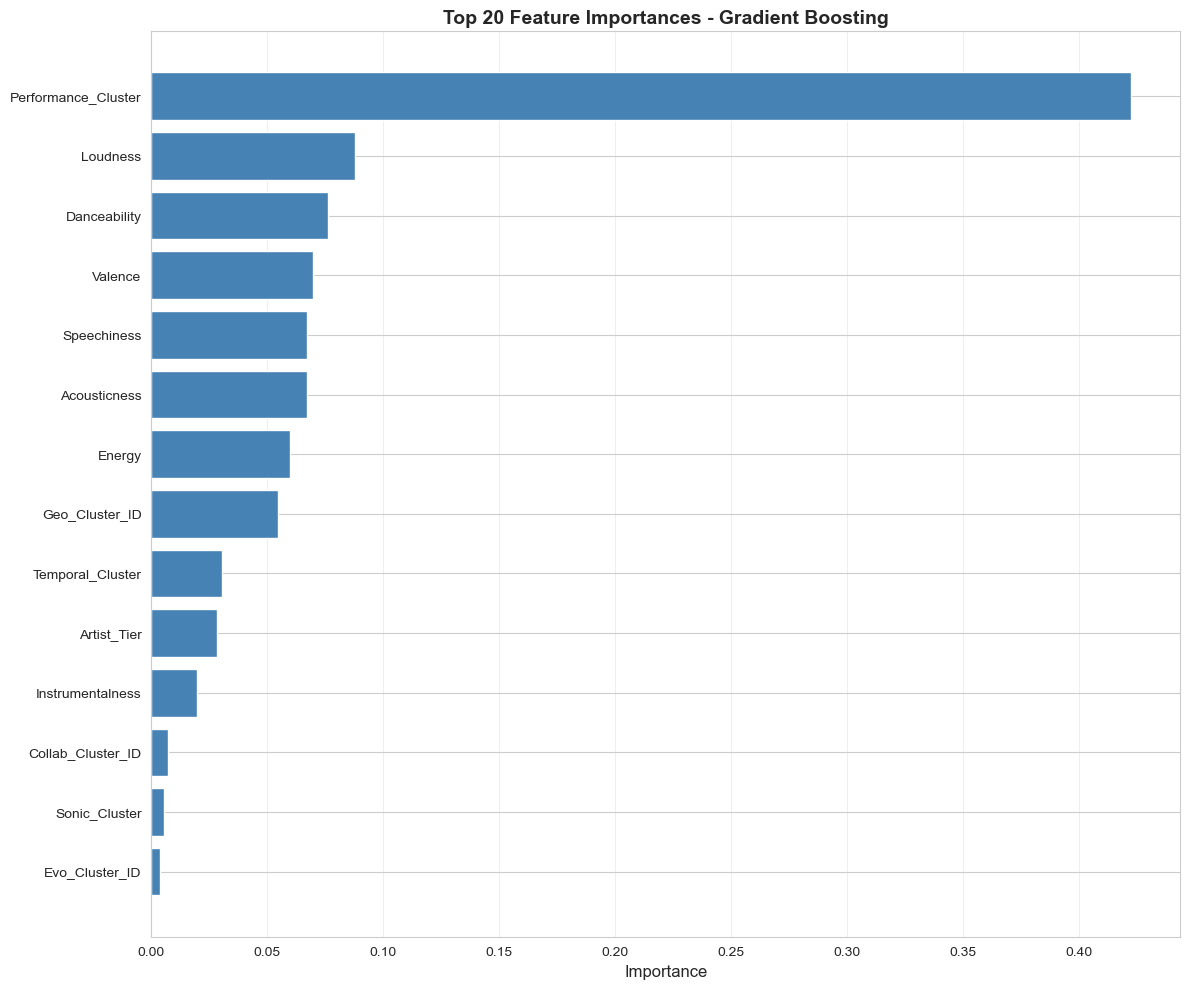

Saved: feature_importance_3class.csv
Categorizing features by type...
FEATURE TYPE IMPORTANCE BREAKDOWN:
Cluster Meta-Features:
  Number of features: 7
  Total importance: 0.5527
  Percentage of total: 55.3 %
  Average importance per feature: 0.079
Original Audio Features:
  Number of features: 7
  Total importance: 0.4473
  Percentage of total: 44.7 %
  Average importance per feature: 0.0639
Key Insight:
  Cluster meta-features are MORE important than original audio features
  Difference: 10.5 percentage points


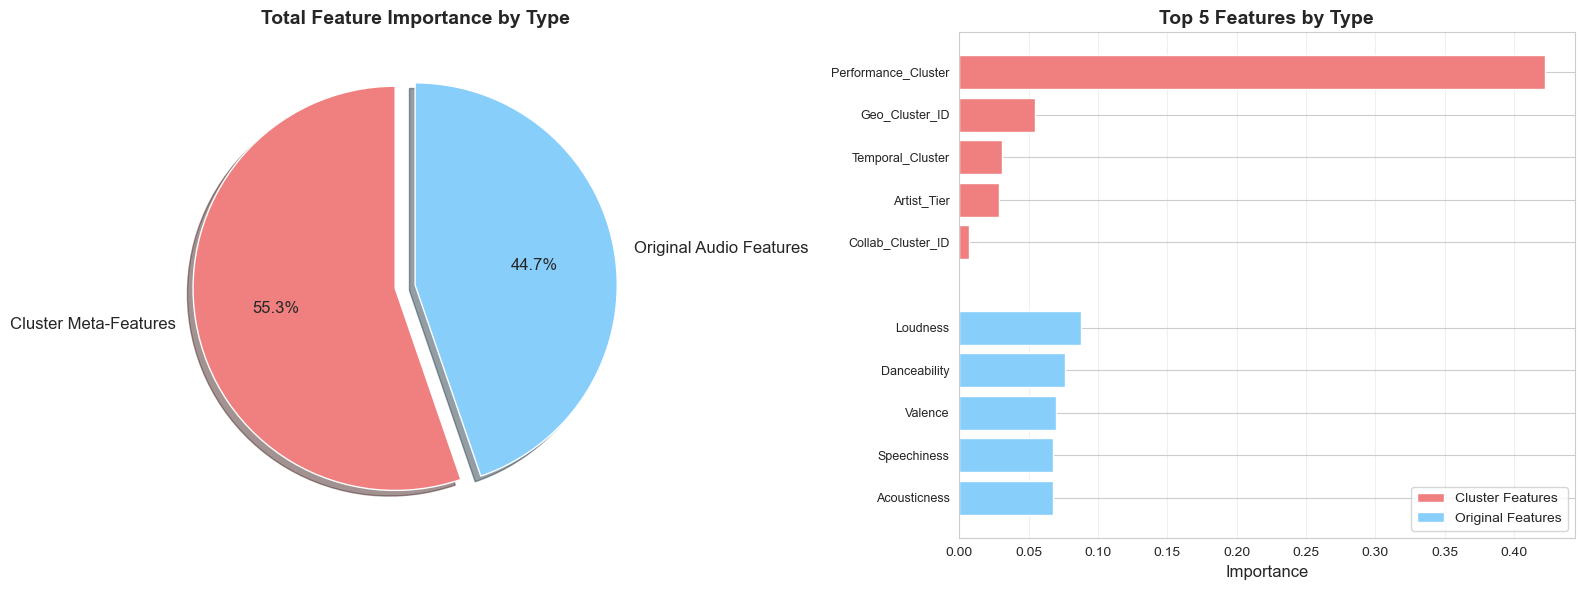

Top 5 Most Important Cluster Meta-Features:
   1 . Performance_Cluster : 0.4224
   2 . Geo_Cluster_ID : 0.0547
   3 . Temporal_Cluster : 0.0307
   4 . Artist_Tier : 0.0285
   5 . Collab_Cluster_ID : 0.0071
Top 5 Most Important Original Audio Features:
   1 . Loudness : 0.0876
   2 . Danceability : 0.076
   3 . Valence : 0.0698
   4 . Speechiness : 0.0673
   5 . Acousticness : 0.0673
IMPORTANCE BY CLUSTER TYPE:
Performance Clusters:
  Total importance: 0.4224
  Percentage: 42.24 %
Geo Clusters:
  Total importance: 0.0547
  Percentage: 5.47 %
Temporal Clusters:
  Total importance: 0.0307
  Percentage: 3.07 %
Artist_Tier Clusters:
  Total importance: 0.0285
  Percentage: 2.85 %
Collab Clusters:
  Total importance: 0.0071
  Percentage: 0.71 %
Sonic Clusters:
  Total importance: 0.0055
  Percentage: 0.55 %
Evo Clusters:
  Total importance: 0.0039
  Percentage: 0.39 %


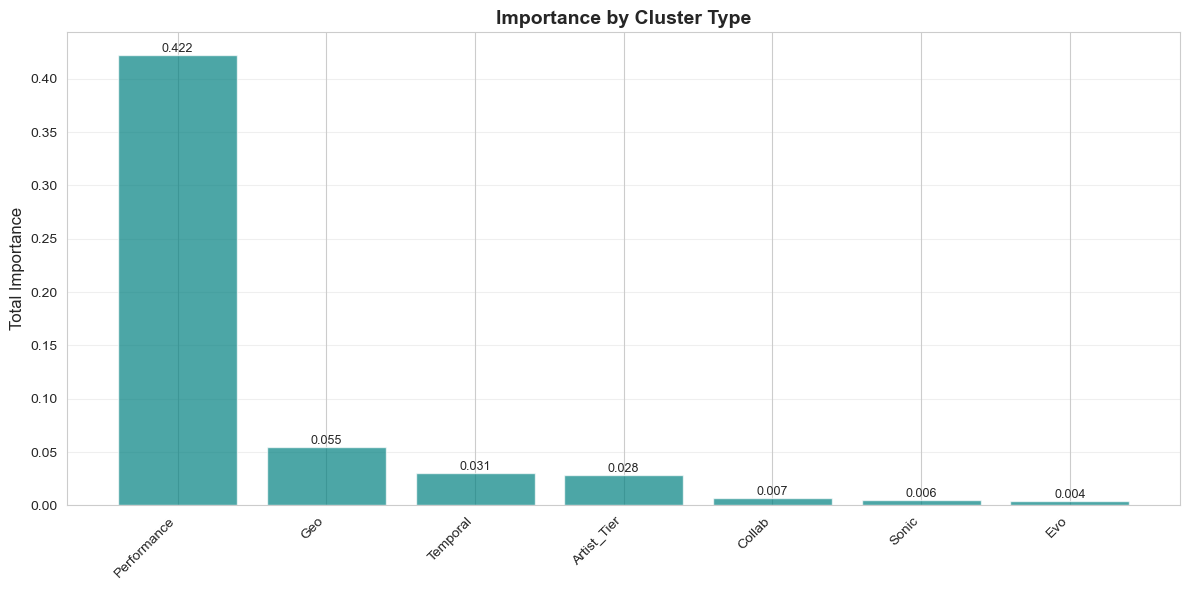

FEATURE IMPORTANCE INSIGHTS:
1. Most Important Single Feature:
   - Performance_Cluster
   - Importance: 0.4224
   - This feature has the strongest predictive power
2. Top 5 Features Combined:
   - Contribute 72.3 % of total importance
   - These few features dominate the model predictions
3. Feature Diversity:
   - Need 8 features to explain 90% of importance
   - Out of 14 total features
   - Using 57.1 % of available features
4. Least Important Features:
   - Bottom 5 features contribute only 6.46 %
Feature importance analysis complete


In [22]:
print("STEP 13: FEATURE IMPORTANCE ANALYSIS")

print("Analyzing feature importance for:", best_model_name)

# Get feature importance from Gradient Boosting model
if hasattr(final_model, 'feature_importances_'):
    feature_importance_final = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 20 Most Important Features:")
    for i in range(min(20, len(feature_importance_final))):
        row = feature_importance_final.iloc[i]
        rank = i + 1
        feature_name = row['Feature']
        importance = row['Importance']
        print(str(rank) + ". " + feature_name + ": " + str(round(importance, 4)))
    
    # Visualize top 20 features
    plt.figure(figsize=(12, 10))
    top_20 = feature_importance_final.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'].values, color='steelblue')
    plt.yticks(range(len(top_20)), top_20['Feature'].values)
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 20 Feature Importances - ' + best_model_name, 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance_final_3class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance
    feature_importance_final.to_csv('feature_importance_3class.csv', index=False)
    print("Saved: feature_importance_3class.csv")
    
    # Analyze cluster vs original features
    print("Categorizing features by type...")
    
    cluster_features = []
    original_features_list = []
    
    for feature in feature_importance_final['Feature']:
        if any(keyword in feature for keyword in ['Cluster', 'Tier', '_ID']):
            cluster_features.append(feature)
        else:
            original_features_list.append(feature)
    
    cluster_importance = feature_importance_final[
        feature_importance_final['Feature'].isin(cluster_features)
    ]['Importance'].sum()
    
    original_importance = feature_importance_final[
        feature_importance_final['Feature'].isin(original_features_list)
    ]['Importance'].sum()
    
    total_importance = cluster_importance + original_importance
    
    print("FEATURE TYPE IMPORTANCE BREAKDOWN:")
    
    print("Cluster Meta-Features:")
    print("  Number of features:", len(cluster_features))
    print("  Total importance:", round(cluster_importance, 4))
    print("  Percentage of total:", round((cluster_importance/total_importance)*100, 1), "%")
    if len(cluster_features) > 0:
        avg_cluster = cluster_importance/len(cluster_features)
        print("  Average importance per feature:", round(avg_cluster, 4))
    
    print("Original Audio Features:")
    print("  Number of features:", len(original_features_list))
    print("  Total importance:", round(original_importance, 4))
    print("  Percentage of total:", round((original_importance/total_importance)*100, 1), "%")
    if len(original_features_list) > 0:
        avg_original = original_importance/len(original_features_list)
        print("  Average importance per feature:", round(avg_original, 4))
    
    # Key insight
    print("Key Insight:")
    if cluster_importance > original_importance:
        print("  Cluster meta-features are MORE important than original audio features")
        print("  Difference:", round((cluster_importance - original_importance)/total_importance*100, 1), "percentage points")
    else:
        print("  Original audio features are MORE important than cluster meta-features")
        print("  Difference:", round((original_importance - cluster_importance)/total_importance*100, 1), "percentage points")
    
    # Create visualization comparing feature types
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pie chart of importance by type
    labels = ['Cluster Meta-Features', 'Original Audio Features']
    sizes = [cluster_importance, original_importance]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)
    
    axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12})
    axes[0].set_title('Total Feature Importance by Type', fontsize=14, fontweight='bold')
    
    # Bar chart showing top features of each type
    top_cluster = feature_importance_final[
        feature_importance_final['Feature'].isin(cluster_features)
    ].head(5)
    
    top_original = feature_importance_final[
        feature_importance_final['Feature'].isin(original_features_list)
    ].head(5)
    
    if len(top_cluster) > 0 or len(top_original) > 0:
        y_positions = []
        importance_values = []
        feature_names = []
        colors_bar = []
        
        current_pos = 0
        for idx, row in top_cluster.iterrows():
            y_positions.append(current_pos)
            importance_values.append(row['Importance'])
            feature_names.append(row['Feature'])
            colors_bar.append('lightcoral')
            current_pos += 1
        
        if len(top_cluster) > 0 and len(top_original) > 0:
            current_pos += 1
        
        for idx, row in top_original.iterrows():
            y_positions.append(current_pos)
            importance_values.append(row['Importance'])
            feature_names.append(row['Feature'])
            colors_bar.append('lightskyblue')
            current_pos += 1
        
        axes[1].barh(y_positions, importance_values, color=colors_bar)
        axes[1].set_yticks(y_positions)
        axes[1].set_yticklabels(feature_names, fontsize=9)
        axes[1].set_xlabel('Importance', fontsize=12)
        axes[1].set_title('Top 5 Features by Type', fontsize=14, fontweight='bold')
        axes[1].invert_yaxis()
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='lightcoral', label='Cluster Features'),
            Patch(facecolor='lightskyblue', label='Original Features')
        ]
        axes[1].legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('feature_importance_by_type_3class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display top features of each type
    if len(top_cluster) > 0:
        print("Top 5 Most Important Cluster Meta-Features:")
        for i, (idx, row) in enumerate(top_cluster.iterrows()):
            print("  ", i+1, ".", row['Feature'], ":", round(row['Importance'], 4))
    
    if len(top_original) > 0:
        print("Top 5 Most Important Original Audio Features:")
        for i, (idx, row) in enumerate(top_original.iterrows()):
            print("  ", i+1, ".", row['Feature'], ":", round(row['Importance'], 4))
    
    # Analyze specific cluster types
    print("IMPORTANCE BY CLUSTER TYPE:")
    
    cluster_types = {
        'Sonic': [],
        'Artist_Tier': [],
        'Temporal': [],
        'Performance': [],
        'Geo': [],
        'Collab': [],
        'Evo': []
    }
    
    for feature in cluster_features:
        if 'Sonic' in feature:
            cluster_types['Sonic'].append(feature)
        elif 'Artist_Tier' in feature or 'Tier' in feature:
            cluster_types['Artist_Tier'].append(feature)
        elif 'Temporal' in feature:
            cluster_types['Temporal'].append(feature)
        elif 'Performance' in feature:
            cluster_types['Performance'].append(feature)
        elif 'Geo' in feature:
            cluster_types['Geo'].append(feature)
        elif 'Collab' in feature:
            cluster_types['Collab'].append(feature)
        elif 'Evo' in feature:
            cluster_types['Evo'].append(feature)
    
    cluster_type_importance = {}
    for cluster_type, features in cluster_types.items():
        if len(features) > 0:
            type_importance = feature_importance_final[
                feature_importance_final['Feature'].isin(features)
            ]['Importance'].sum()
            cluster_type_importance[cluster_type] = type_importance
    
    # Sort by importance
    sorted_cluster_types = sorted(cluster_type_importance.items(), key=lambda x: x[1], reverse=True)
    
    for cluster_type, importance in sorted_cluster_types:
        percent = (importance / total_importance) * 100
        print(cluster_type + " Clusters:")
        print("  Total importance:", round(importance, 4))
        print("  Percentage:", round(percent, 2), "%")
    
    # Visualize cluster type importance
    if len(sorted_cluster_types) > 0:
        plt.figure(figsize=(12, 6))
        cluster_names = [item[0] for item in sorted_cluster_types]
        cluster_values = [item[1] for item in sorted_cluster_types]
        
        plt.bar(range(len(cluster_names)), cluster_values, color='teal', alpha=0.7)
        plt.xticks(range(len(cluster_names)), cluster_names, rotation=45, ha='right')
        plt.ylabel('Total Importance', fontsize=12)
        plt.title('Importance by Cluster Type', fontsize=14, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i in range(len(cluster_values)):
            plt.text(i, cluster_values[i], str(round(cluster_values[i], 3)),
                    ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('cluster_type_importance_3class.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Summary insights
    print("FEATURE IMPORTANCE INSIGHTS:")
    
    # Most important single feature
    most_important = feature_importance_final.iloc[0]
    print("1. Most Important Single Feature:")
    print("   -", most_important['Feature'])
    print("   - Importance:", round(most_important['Importance'], 4))
    print("   - This feature has the strongest predictive power")
    
    # Top 5 features contribution
    top_5_importance = feature_importance_final.head(5)['Importance'].sum()
    top_5_percent = (top_5_importance / total_importance) * 100
    print("2. Top 5 Features Combined:")
    print("   - Contribute", round(top_5_percent, 1), "% of total importance")
    if top_5_percent > 50:
        print("   - These few features dominate the model predictions")
    else:
        print("   - Model uses a diverse set of features")
    
    # Feature diversity
    features_for_90_percent = 0
    cumulative = 0
    for idx, row in feature_importance_final.iterrows():
        cumulative += row['Importance']
        features_for_90_percent += 1
        if cumulative >= 0.90 * total_importance:
            break
    
    print("3. Feature Diversity:")
    print("   - Need", features_for_90_percent, "features to explain 90% of importance")
    print("   - Out of", len(X.columns), "total features")
    diversity_percent = (features_for_90_percent / len(X.columns)) * 100
    print("   - Using", round(diversity_percent, 1), "% of available features")
    
    # Least important features
    bottom_5 = feature_importance_final.tail(5)
    bottom_5_importance = bottom_5['Importance'].sum()
    bottom_5_percent = (bottom_5_importance / total_importance) * 100
    print("4. Least Important Features:")
    print("   - Bottom 5 features contribute only", round(bottom_5_percent, 2), "%")
    if bottom_5_percent < 1:
        print("   - These features could potentially be removed")
    
else:
    print("Selected model does not support native feature importance")
    print("Computing permutation importance as alternative...")
    
    from sklearn.inspection import permutation_importance
    
    print("This may take a few minutes...")
    perm_importance = permutation_importance(
        final_model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    feature_importance_final = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features (Permutation Importance):")
    print(feature_importance_final.head(15).to_string(index=False))
    
    feature_importance_final.to_csv('feature_importance_3class.csv', index=False)
    print("Saved: feature_importance_3class.csv")

print("Feature importance analysis complete")

STEP 14: PER-CLASS PERFORMANCE ANALYSIS
Analyzing how the model performs on each success category...
Flop:
  Total test samples: 357
  Correctly predicted: 202
  Incorrectly predicted: 155
  Accuracy: 56.58 %
  Precision: 48.21 %
  Recall: 56.58 %
  F1-Score: 52.06 %
  Most common misclassification: Moderate Hit
    Misclassified as this: 131 times ( 36.7 % )
  All misclassifications:
    - Long-Term Hit: 24 ( 6.7 % )
    - Moderate Hit: 131 ( 36.7 % )
Long-Term Hit:
  Total test samples: 724
  Correctly predicted: 499
  Incorrectly predicted: 225
  Accuracy: 68.92 %
  Precision: 67.16 %
  Recall: 68.92 %
  F1-Score: 68.03 %
  Most common misclassification: Moderate Hit
    Misclassified as this: 161 times ( 22.2 % )
  All misclassifications:
    - Flop: 64 ( 8.8 % )
    - Moderate Hit: 161 ( 22.2 % )
Moderate Hit:
  Total test samples: 752
  Correctly predicted: 379
  Incorrectly predicted: 373
  Accuracy: 50.4 %
  Precision: 56.48 %
  Recall: 50.4 %
  F1-Score: 53.27 %
  Most common 

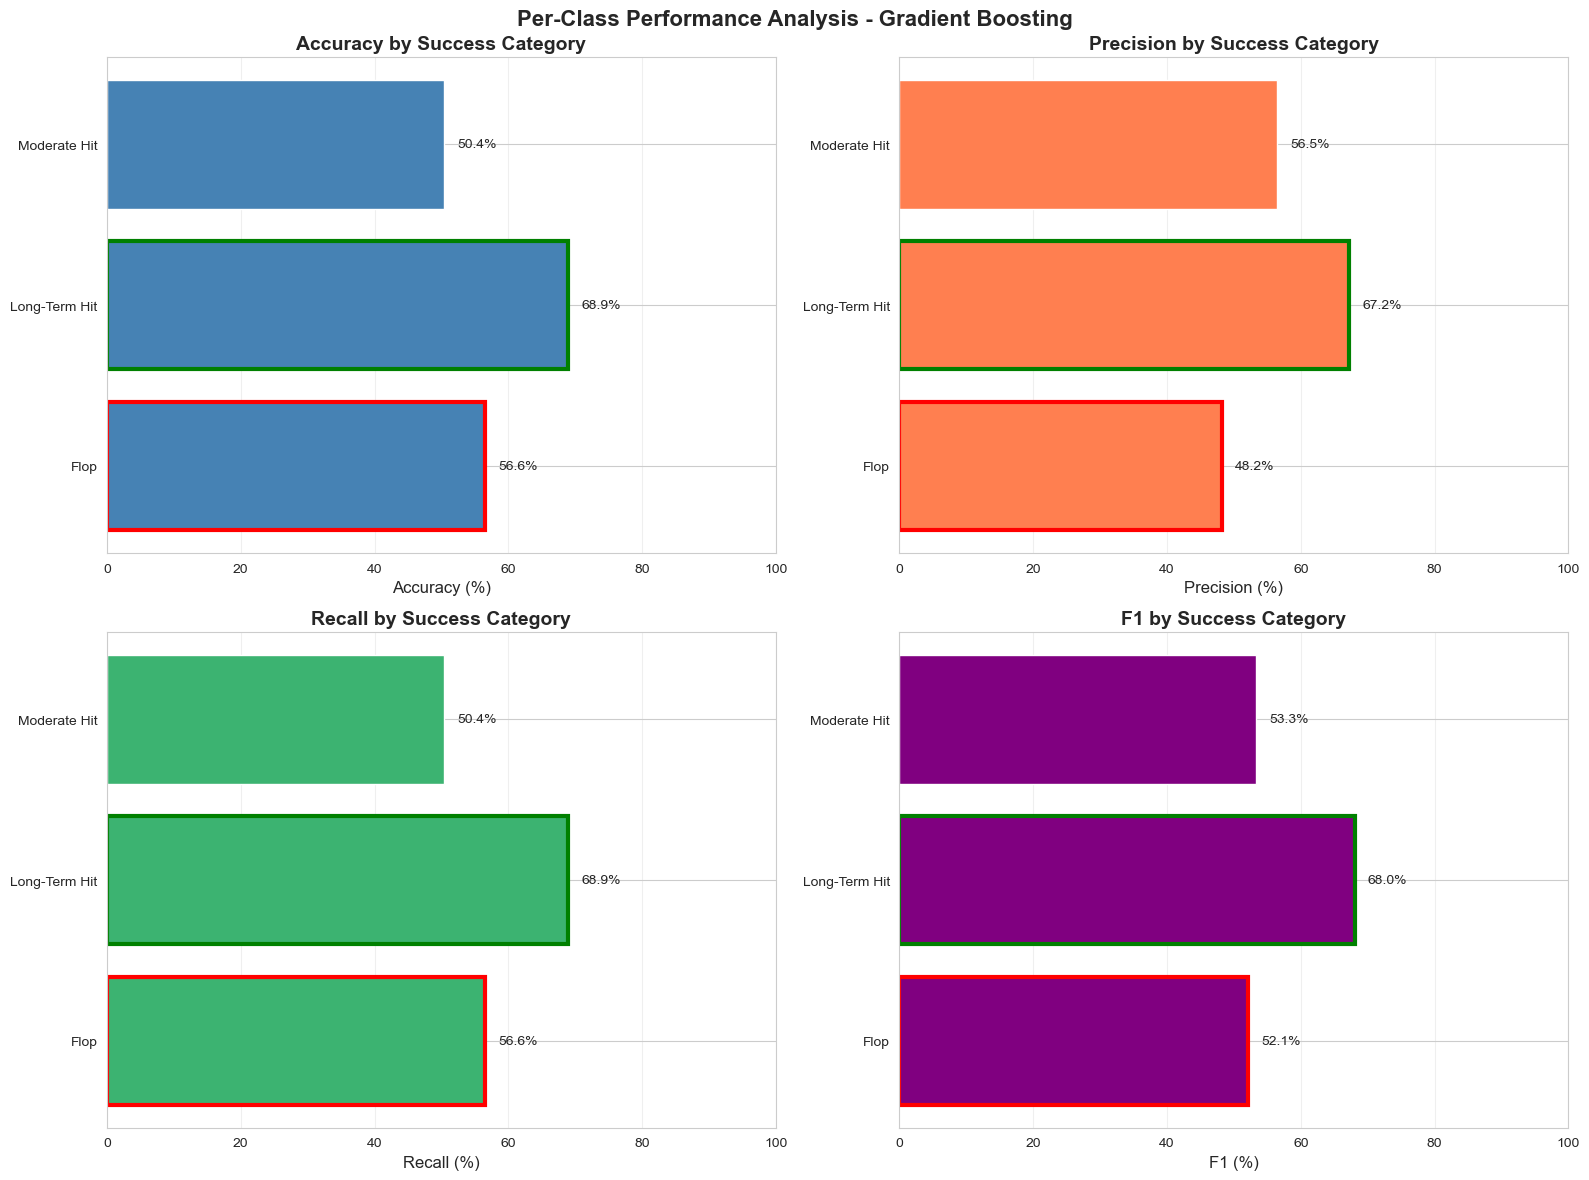

DETAILED PER-CLASS METRICS TABLE:
        Class  Total_Samples  Correct  Incorrect  Accuracy  Precision    Recall        F1
         Flop            357      202        155 56.582633  48.210024 56.582633 52.061856
Long-Term Hit            724      499        225 68.922652  67.160162 68.922652 68.029993
 Moderate Hit            752      379        373 50.398936  56.482861 50.398936 53.267744
Saved: per_class_performance_3class.csv
CONFUSION PATTERN ANALYSIS:
Confusion Matrix:
               Flop  Long-Term Hit  Moderate Hit
Flop            202             24           131
Long-Term Hit    64            499           161
Moderate Hit    153            220           379
Most Common Confusion Patterns:
1. Actually Moderate Hit but predicted as Long-Term Hit
   Count: 220 ( 29.3 % of actual Moderate Hit )
2. Actually Long-Term Hit but predicted as Moderate Hit
   Count: 161 ( 22.2 % of actual Long-Term Hit )
3. Actually Moderate Hit but predicted as Flop
   Count: 153 ( 20.3 % of actual Mod

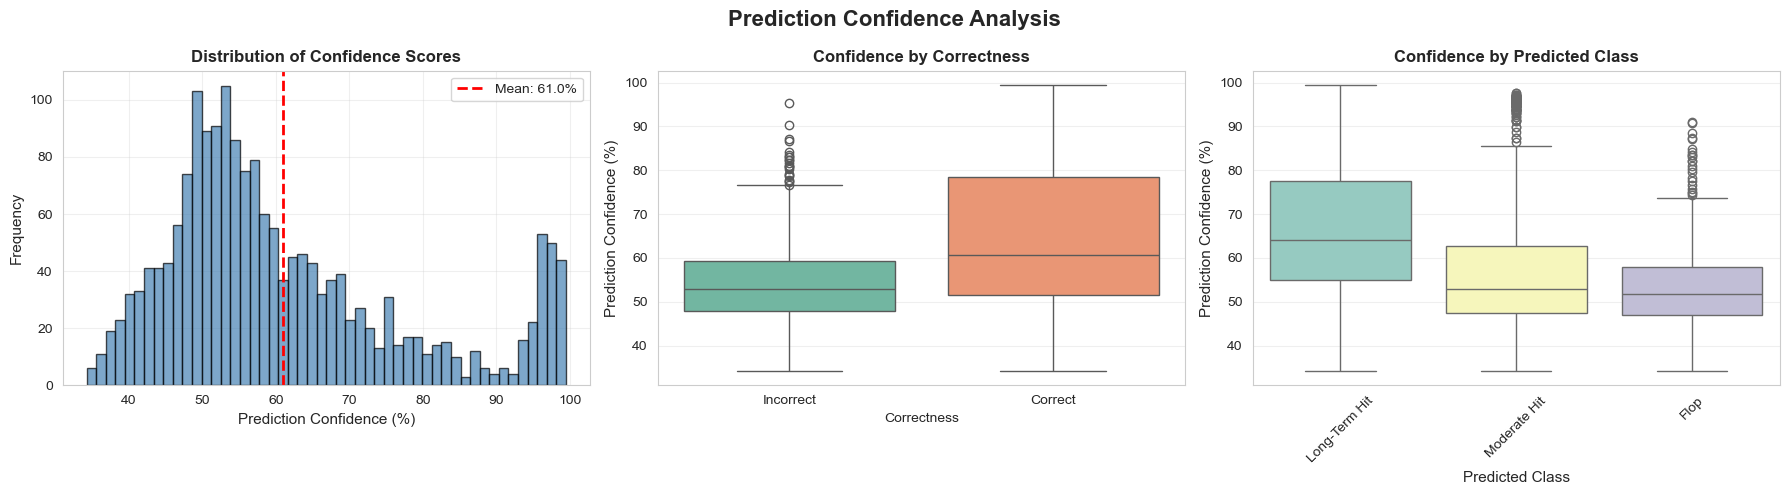

LOW CONFIDENCE PREDICTIONS ANALYSIS:
Total low confidence predictions (<50%): 489
Percentage of total: 26.7 %
Accuracy on low confidence predictions: 45.19 %
Model is struggling with these predictions - consider flagging for review
Per-class performance analysis complete


In [23]:
print("STEP 14: PER-CLASS PERFORMANCE ANALYSIS")

print("Analyzing how the model performs on each success category...")

# Analyze predictions by category
class_performance = []

for class_idx in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[class_idx]
    
    # Get samples from this class
    class_mask = (y_test == class_idx)
    class_predictions = y_pred_final[class_mask]
    
    # Calculate metrics
    total_in_class = class_mask.sum()
    correctly_predicted = (class_predictions == class_idx).sum()
    class_accuracy = correctly_predicted / total_in_class if total_in_class > 0 else 0
    
    # Calculate precision, recall, F1 for this specific class
    true_positives = correctly_predicted
    false_positives = ((y_pred_final == class_idx) & (y_test != class_idx)).sum()
    false_negatives = ((y_pred_final != class_idx) & (y_test == class_idx)).sum()
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    class_performance.append({
        'Class': class_name,
        'Total_Samples': total_in_class,
        'Correct': correctly_predicted,
        'Incorrect': total_in_class - correctly_predicted,
        'Accuracy': class_accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1': f1 * 100
    })
    
    print(class_name + ":")
    print("  Total test samples:", total_in_class)
    print("  Correctly predicted:", correctly_predicted)
    print("  Incorrectly predicted:", total_in_class - correctly_predicted)
    print("  Accuracy:", round(class_accuracy*100, 2), "%")
    print("  Precision:", round(precision*100, 2), "%")
    print("  Recall:", round(recall*100, 2), "%")
    print("  F1-Score:", round(f1*100, 2), "%")
    
    # Show most common misclassification
    if len(class_predictions) > 0:
        misclassified = class_predictions[class_predictions != class_idx]
        if len(misclassified) > 0:
            misclass_unique, misclass_counts = np.unique(misclassified, return_counts=True)
            most_common_idx = misclass_unique[np.argmax(misclass_counts)]
            most_common_count = misclass_counts[np.argmax(misclass_counts)]
            error_pct = (most_common_count / total_in_class) * 100
            print("  Most common misclassification:", label_encoder.classes_[most_common_idx])
            print("    Misclassified as this:", most_common_count, "times (", round(error_pct, 1), "% )")
            
            # Show all misclassifications
            if len(misclass_unique) > 1:
                print("  All misclassifications:")
                for mis_idx, mis_count in zip(misclass_unique, misclass_counts):
                    mis_class_name = label_encoder.classes_[mis_idx]
                    mis_pct = (mis_count / total_in_class) * 100
                    print("    -", mis_class_name + ":", mis_count, "(", round(mis_pct, 1), "% )")

# Create dataframe
class_perf_df = pd.DataFrame(class_performance)

# Overall statistics
print("OVERALL PER-CLASS STATISTICS:")

best_class = class_perf_df.loc[class_perf_df['F1'].idxmax()]
worst_class = class_perf_df.loc[class_perf_df['F1'].idxmin()]

print("Best Performing Class:", best_class['Class'])
print("  F1-Score:", round(best_class['F1'], 2), "%")
print("  Model is most accurate at predicting this category")

print("Worst Performing Class:", worst_class['Class'])
print("  F1-Score:", round(worst_class['F1'], 2), "%")
print("  Model struggles most with this category")

print("Performance Variance:")
f1_range = best_class['F1'] - worst_class['F1']
print("  F1-Score range:", round(f1_range, 2), "percentage points")
if f1_range > 20:
    print("  High variance - model performance is inconsistent across classes")
elif f1_range > 10:
    print("  Moderate variance - some classes easier to predict than others")
else:
    print("  Low variance - model performs similarly across all classes")

# Visualize per-class performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Per-Class Performance Analysis - ' + best_model_name, fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for idx in range(len(metrics)):
    metric = metrics[idx]
    color = colors[idx]
    row = idx // 2
    col = idx % 2
    
    bars = axes[row, col].barh(class_perf_df['Class'], class_perf_df[metric], color=color)
    axes[row, col].set_xlabel(metric + ' (%)', fontsize=12)
    axes[row, col].set_title(metric + ' by Success Category', fontsize=14, fontweight='bold')
    axes[row, col].set_xlim(0, 100)
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i in range(len(class_perf_df)):
        cat = class_perf_df['Class'].iloc[i]
        value = class_perf_df[metric].iloc[i]
        axes[row, col].text(value + 2, i, str(round(value, 1)) + '%', 
                           va='center', fontsize=10)
    
    # Highlight best and worst
    for i, bar in enumerate(bars):
        if class_perf_df['Class'].iloc[i] == best_class['Class']:
            bar.set_edgecolor('green')
            bar.set_linewidth(3)
        elif class_perf_df['Class'].iloc[i] == worst_class['Class']:
            bar.set_edgecolor('red')
            bar.set_linewidth(3)

plt.tight_layout()
plt.savefig('per_class_performance_3class.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary comparison table
print("DETAILED PER-CLASS METRICS TABLE:")
print(class_perf_df.to_string(index=False))

# Save per-class performance
class_perf_df.to_csv('per_class_performance_3class.csv', index=False)
print("Saved: per_class_performance_3class.csv")

# Analyze confusion patterns
print("CONFUSION PATTERN ANALYSIS:")

confusion_df = pd.DataFrame(
    final_conf_matrix,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)

print("Confusion Matrix:")
print(confusion_df)

# Calculate most common confusion pairs
print("Most Common Confusion Patterns:")
confusion_pairs = []
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        if i != j:
            actual_class = label_encoder.classes_[i]
            predicted_class = label_encoder.classes_[j]
            count = final_conf_matrix[i, j]
            total_actual = final_conf_matrix[i, :].sum()
            percent = (count / total_actual * 100) if total_actual > 0 else 0
            confusion_pairs.append({
                'Actual': actual_class,
                'Predicted': predicted_class,
                'Count': count,
                'Percent': percent
            })

confusion_pairs_df = pd.DataFrame(confusion_pairs)
confusion_pairs_df = confusion_pairs_df.sort_values('Count', ascending=False)

for i in range(min(5, len(confusion_pairs_df))):
    row = confusion_pairs_df.iloc[i]
    print(str(i+1) + ". Actually", row['Actual'], "but predicted as", row['Predicted'])
    print("   Count:", int(row['Count']), "(", round(row['Percent'], 1), "% of actual", row['Actual'], ")")

# Prediction confidence analysis
if hasattr(final_model, 'predict_proba'):
    print("PREDICTION CONFIDENCE ANALYSIS:")
    
    y_proba = final_model.predict_proba(X_test)
    prediction_confidence = np.max(y_proba, axis=1)
    
    print("Overall Confidence Statistics:")
    print("  Average confidence:", round(prediction_confidence.mean()*100, 2), "%")
    print("  Median confidence:", round(np.median(prediction_confidence)*100, 2), "%")
    print("  Min confidence:", round(prediction_confidence.min()*100, 2), "%")
    print("  Max confidence:", round(prediction_confidence.max()*100, 2), "%")
    print("  Std deviation:", round(prediction_confidence.std()*100, 2), "percentage points")
    
    print("Confidence Distribution:")
    very_high = (prediction_confidence > 0.9).sum()
    high = ((prediction_confidence > 0.8) & (prediction_confidence <= 0.9)).sum()
    medium = ((prediction_confidence > 0.6) & (prediction_confidence <= 0.8)).sum()
    low = ((prediction_confidence > 0.4) & (prediction_confidence <= 0.6)).sum()
    very_low = (prediction_confidence <= 0.4).sum()
    
    total = len(prediction_confidence)
    print("  Very High (>90%):", very_high, "predictions (", round(very_high/total*100, 1), "% )")
    print("  High (80-90%):", high, "predictions (", round(high/total*100, 1), "% )")
    print("  Medium (60-80%):", medium, "predictions (", round(medium/total*100, 1), "% )")
    print("  Low (40-60%):", low, "predictions (", round(low/total*100, 1), "% )")
    print("  Very Low (<40%):", very_low, "predictions (", round(very_low/total*100, 1), "% )")
    
    # Confidence by correctness
    correct_predictions = (y_pred_final == y_test)
    correct_confidence = prediction_confidence[correct_predictions].mean()
    incorrect_confidence = prediction_confidence[~correct_predictions].mean()
    
    print("Confidence by Prediction Correctness:")
    print("  Correct predictions average confidence:", round(correct_confidence*100, 2), "%")
    print("  Incorrect predictions average confidence:", round(incorrect_confidence*100, 2), "%")
    print("  Difference:", round((correct_confidence - incorrect_confidence)*100, 2), "percentage points")
    
    if correct_confidence > incorrect_confidence:
        print("  Good sign: Model is more confident when correct")
    else:
        print("  Warning: Model is equally or more confident when wrong")
    
    # Confidence by class
    print("Average Confidence by Class:")
    for class_idx in range(len(label_encoder.classes_)):
        class_name = label_encoder.classes_[class_idx]
        class_mask = (y_pred_final == class_idx)
        if class_mask.sum() > 0:
            class_confidence = prediction_confidence[class_mask].mean()
            print("  ", class_name + ":", round(class_confidence*100, 2), "%")
    
    # Visualize confidence analysis
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')
    
    # Histogram of all confidences
    axes[0].hist(prediction_confidence * 100, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(prediction_confidence.mean() * 100, color='red', linestyle='--', 
                   linewidth=2, label='Mean: ' + str(round(prediction_confidence.mean()*100, 1)) + '%')
    axes[0].set_xlabel('Prediction Confidence (%)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Distribution of Confidence Scores', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot: confidence by correctness
    confidence_df = pd.DataFrame({
        'Confidence': prediction_confidence * 100,
        'Correctness': ['Correct' if c else 'Incorrect' for c in correct_predictions]
    })
    
    sns.boxplot(data=confidence_df, x='Correctness', y='Confidence', ax=axes[1], palette='Set2')
    axes[1].set_ylabel('Prediction Confidence (%)', fontsize=11)
    axes[1].set_title('Confidence by Correctness', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Box plot: confidence by predicted class
    confidence_by_class_df = pd.DataFrame({
        'Confidence': prediction_confidence * 100,
        'Predicted_Class': [label_encoder.classes_[i] for i in y_pred_final]
    })
    
    sns.boxplot(data=confidence_by_class_df, x='Predicted_Class', y='Confidence', 
                ax=axes[2], palette='Set3')
    axes[2].set_xlabel('Predicted Class', fontsize=11)
    axes[2].set_ylabel('Prediction Confidence (%)', fontsize=11)
    axes[2].set_title('Confidence by Predicted Class', fontsize=12, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('prediction_confidence_3class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Low confidence predictions analysis
    low_confidence_threshold = 0.5
    low_confidence_mask = prediction_confidence < low_confidence_threshold
    num_low_confidence = low_confidence_mask.sum()
    
    if num_low_confidence > 0:
        print("LOW CONFIDENCE PREDICTIONS ANALYSIS:")
        print("Total low confidence predictions (<50%):", num_low_confidence)
        print("Percentage of total:", round(num_low_confidence/total*100, 1), "%")
        
        low_conf_correct = (correct_predictions & low_confidence_mask).sum()
        low_conf_accuracy = low_conf_correct / num_low_confidence * 100
        print("Accuracy on low confidence predictions:", round(low_conf_accuracy, 2), "%")
        
        if low_conf_accuracy < 50:
            print("Model is struggling with these predictions - consider flagging for review")

print("Per-class performance analysis complete")